In [1]:
import pandas as pd
from pathlib import Path
import os
import csv
import glob
import shutil
from collections import Counter
import numpy as np
import tensorflow as tf
import keras
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
import matplotlib.pyplot as plt
import seaborn as sb
import cv2
from scipy import ndimage
import sklearn
from scipy.ndimage import zoom
from random import shuffle
from keras.layers import *
from keras.models import Model, load_model
import tensorflow.keras.backend as K
from tensorflow import losses, optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from scipy.ndimage import shift
from scipy.ndimage import map_coordinates
from sklearn.model_selection import StratifiedKFold 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, classification_report
from itertools import chain
from scipy.ndimage import gaussian_filter
from skimage.color import rgb2gray
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight

2025-01-07 19:50:24.144602: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-07 19:50:24.166224: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-07 19:50:24.182741: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-07 19:50:24.187539: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-07 19:50:24.200078: I tensorflow/core/platform/cpu_feature_guar

In [2]:
# Image size for resizing
image_size = (128, 128)  # Adjust based on your preference or model requirements

# Function to load images and labels
def load_data(folder):
    images = []
    labels = []
    class_names = sorted(os.listdir(folder))  # Sort to ensure consistent label ordering
    class_to_label = {class_name: idx for idx, class_name in enumerate(class_names)}
    
    for class_name in class_names:
        class_folder = os.path.join(folder, class_name)
        if not os.path.isdir(class_folder):
            continue
        for image_name in tqdm(os.listdir(class_folder)):
            image_path = os.path.join(class_folder, image_name)
            try:
                # Read and resize image
                image = cv2.imread(image_path)
                if image is not None:
                    image = cv2.resize(image, image_size)
                    image = image[:,:,0]
                    image = image.reshape(128, 128, 1)
                    images.append(image)
                    labels.append(class_to_label[class_name])
            except Exception as e:
                print(f"Error loading image {image_path}: {e}")
    
    return np.array(images), np.array(labels), class_to_label

# Load the dataset
x_train, y_train, class_mapping_train = load_data('/mnt/c/Users/Dhruba/Data/OCTDL/train')
x_test, y_test, class_mapping_test = load_data('/mnt/c/Users/Dhruba/Data/OCTDL/test')

# Normalize images (optional, recommended for deep learning)
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Print dataset details
print(f"x_training data shape: {x_train.shape} and test data shape: {x_test.shape}: ")
print(f"x_training label shape: {y_train.shape} and test label shape: {y_test.shape}: ")
print(f"Class mapping: {class_mapping_train}")

# y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test)

print("Train label shape:", y_train.shape)
print("Test encoded label shape:", y_test_encoded.shape)

100%|███████████████████████████████████████████████████████████████████████████████████| 18/18 [00:01<00:00, 16.77it/s]


x_training data shape: (1635, 128, 128, 1) and test data shape: (429, 128, 128, 1): 
x_training label shape: (1635,) and test label shape: (429,): 
Class mapping: {'AMD': 0, 'DME': 1, 'ERM': 2, 'NO': 3, 'RAO': 4, 'RVO': 5, 'VID': 6}
Train label shape: (1635,)
Test encoded label shape: (429, 7)


In [3]:
def split_dataset(x_train, y_train, num_splits):
    """
    Splits a dataset into smaller datasets such that all classes are present in each split.
    Returns:
        list: A list of tuples, where each tuple contains a smaller dataset (x_split, y_split).
    """   
    # StratifiedKFold will split maintaining class distribution
    skf = StratifiedKFold(n_splits=num_splits, shuffle=True, random_state=42)
    # y_train = np.argmax(y_train_encoded, axis=1)
    
    splits = []
    for _, split_indices in tqdm(skf.split(x_train, y_train)):
        x_split = x_train[split_indices]
        y_split = y_train[split_indices]
        splits.append((x_split, y_split))

    # Accessing each split
    x_train1, y_train1 = splits[0]
    x_train2, y_train2 = splits[1]
    x_train3, y_train3 = splits[2]
    return x_train1, x_train2, x_train3, y_train1, y_train2, y_train3

# Split into 20 parts
x_train1, x_train2, x_train3, y_train1, y_train2, y_train3 = split_dataset(x_train, y_train, num_splits=3)

# # Example: Check the size and classes in each split
# for i, (x_split, y_split) in enumerate(splits):
#     print(f"Split {i+1}: {len(x_split)} samples, Classes: {np.unique(y_split)}")

3it [00:00, 53.95it/s]


In [16]:
def translate_image(image, shift_x, shift_y):
    """
    Translate the image by shift_x and shift_y.
    Uses constant fill for pixels outside boundaries.
    """
    return shift(image, shift=(shift_y, shift_x, 0), mode='constant', cval=0.0)

# Create translated datasets 1
x_train_translated_pos1 = np.array([translate_image(img, 20, 20) for img in tqdm(x_train1[495:])])  # +20 pixels in both directions
y_train_tpos1 = y_train1[495:]
x_train_translated_neg1 = np.array([translate_image(img, -20, -20) for img in tqdm(x_train1[495:])])  # -20 pixels in both directions
y_train_tneg1 = y_train1[495:]

# Create translated datasets 2
x_train_translated_pos2 = np.array([translate_image(img, 20, 20) for img in tqdm(x_train2[495:])])  # +20 pixels in both directions
y_train_tpos2 = y_train2[495:]
x_train_translated_neg2 = np.array([translate_image(img, -20, -20) for img in tqdm(x_train2[495:])])  # -20 pixels in both directions
y_train_tneg2 = y_train2[495:]

# Create translated datasets 3
x_train_translated_pos3 = np.array([translate_image(img, 20, 20) for img in tqdm(x_train3[495:])])  # +20 pixels in both directions
y_train_tpos3 = y_train3[495:]
x_train_translated_neg3 = np.array([translate_image(img, -20, -20) for img in tqdm(x_train3[495:])])  # -20 pixels in both directions
y_train_tneg3 = y_train3[495:]

# Combine original and translated data
x_train_augmented1 = np.concatenate((x_train1, x_train_translated_pos1, x_train_translated_neg1), axis=0)
y_train_augmented1 = np.concatenate((y_train1, y_train_tpos1, y_train_tneg1), axis=0)

x_train_augmented2 = np.concatenate((x_train2, x_train_translated_pos2, x_train_translated_neg2), axis=0)
y_train_augmented2 = np.concatenate((y_train2, y_train_tpos2, y_train_tneg2), axis=0)

x_train_augmented3 = np.concatenate((x_train3, x_train_translated_pos3, x_train_translated_neg3), axis=0)
y_train_augmented3 = np.concatenate((y_train3, y_train_tpos3, y_train_tneg3), axis=0)

# Check the shapes for confirmation
print("Original dataset shape:", x_train1.shape)
print("Augmented dataset shape:", x_train_augmented1.shape)
print("Augmented label shape:", y_train_augmented1.shape)


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 127.53it/s]


Original dataset shape: (545, 128, 128, 1)
Augmented dataset shape: (645, 128, 128, 1)
Augmented label shape: (645,)


In [17]:
def scaleit(image, factor, isseg=False):
    order = 0 if isseg == True else 1
    height, width = image.shape[:2]   
# For multichannel images we don't want to apply the zoom factor to the channel dimension, so instead we create a tuple of zoom 
# factors, one per array dimension, with 1's for any trailing dimensions after the width and height.  
    zoom_tuple = (factor,)*2 + (1,)*(image.ndim - 2) 
    
    if factor < 1.0:
        zheight = int(np.round(factor * height))
        zwidth  = int(np.round(factor * width))
        newimg  = np.zeros_like(image)
        row     = (height - zheight) // 2
        col     = (width - zwidth) // 2
        newimg[row:row+zheight, col:col+zwidth] = zoom(image, zoom_tuple, order=order, mode='nearest')
        return newimg
    
    elif factor > 1.0:
        zheight = int(np.round(height / factor))
        zwidth  = int(np.round(width / factor))
        row     = (height - zheight) // 2
        col     = (width - zwidth) // 2
        
        newimg = zoom(image[row:row+zheight, col:col+zwidth], zoom_tuple, order=order, mode='nearest')
# `newimg` might still be slightly larger than `img` due to rounding, so trim off any extra pixels at the edges
        trim_row = ((newimg.shape[0] - height) // 2)
        trim_col = ((newimg.shape[1] - width) // 2)
        newimg = newimg[trim_row:trim_row+height, trim_col:trim_col+width]
        return newimg
    
# If zoom_factor == 1, just return the input array
    else:
        return image

img_aug_array=[]
label_array = []
zoom_factor = [0.90, 0.95, 1.05, 1.10]
for d in tqdm(range(x_train1.shape[0])): 
    for e in range (4):
            volume = scaleit(x_train1[d], zoom_factor[e], isseg=False)
            img_aug_array.append(volume)
            label = y_train1[d]
            label_array.append(label)
        
x_train_scaled = np.array(img_aug_array, np.float32)
print(x_train_scaled.shape)
y_train_scaled = np.array(label_array, np.float32)
print(y_train_scaled.shape)
x_train_augmented1 = np.concatenate((x_train_augmented1, x_train_scaled), axis=0)
y_train_augmented1 = np.concatenate((y_train_augmented1, y_train_scaled), axis=0)
img_aug_array=[]
label_array = []
for d in tqdm(range(x_train2.shape[0])): 
    for e in range (4):
            volume = scaleit(x_train2[d], zoom_factor[e], isseg=False)
            img_aug_array.append(volume)
            label = y_train2[d]
            label_array.append(label)
        
x_train_scaled = np.array(img_aug_array, np.float32)
print(x_train_scaled.shape)
y_train_scaled = np.array(label_array, np.float32)
print(y_train_scaled.shape)
x_train_augmented2 = np.concatenate((x_train_augmented2, x_train_scaled), axis=0)
y_train_augmented2 = np.concatenate((y_train_augmented2, y_train_scaled), axis=0)
img_aug_array=[]
label_array = []
for d in tqdm(range(x_train3.shape[0])): 
    for e in range (4):
            volume = scaleit(x_train3[d], zoom_factor[e], isseg=False)
            img_aug_array.append(volume)
            label = y_train3[d]
            label_array.append(label)
        
x_train_scaled = np.array(img_aug_array, np.float32)
print(x_train_scaled.shape)
y_train_scaled = np.array(label_array, np.float32)
print(y_train_scaled.shape)
x_train_augmented3 = np.concatenate((x_train_augmented3, x_train_scaled), axis=0)
y_train_augmented3 = np.concatenate((y_train_augmented3, y_train_scaled), axis=0)

100%|████████████████████████████████████████████████████████████████████████████████| 545/545 [00:02<00:00, 237.79it/s]


(2180, 128, 128, 1)
(2180,)


100%|████████████████████████████████████████████████████████████████████████████████| 545/545 [00:01<00:00, 307.37it/s]


(2180, 128, 128, 1)
(2180,)


100%|████████████████████████████████████████████████████████████████████████████████| 545/545 [00:02<00:00, 254.58it/s]

(2180, 128, 128, 1)
(2180,)


In [18]:
angles = np.arange(-40, 41, 5)
img_aug_array= []
label_array = []

for d in tqdm(range(x_train1.shape[0])): 
    for e in range (17):
            volume = ndimage.rotate(x_train1[d], angles[e], reshape=False, order=1) 
            img_aug_array.append(volume)
            label = y_train1[d]
            label_array.append(label)
        
x_aug_ang = np.array(img_aug_array, np.float32)
print(x_aug_ang.shape)
y_aug_ang = np.array(label_array, np.float32)
print(y_aug_ang.shape)

# Combine original and scaled datasets
x_train_augmented1 = np.concatenate((x_train_augmented1, x_aug_ang), axis=0)
y_train_augmented1 = np.concatenate((y_train_augmented1, y_aug_ang), axis=0)

img_aug_array= []
label_array = []
for d in tqdm(range(x_train2.shape[0])): 
    for e in range (17):
            volume = ndimage.rotate(x_train2[d], angles[e], reshape=False, order=1) 
            img_aug_array.append(volume)
            label = y_train2[d]
            label_array.append(label)
        
x_aug_ang = np.array(img_aug_array, np.float32)
print(x_aug_ang.shape)
y_aug_ang = np.array(label_array, np.float32)
print(y_aug_ang.shape)

# Combine original and scaled datasets
x_train_augmented2 = np.concatenate((x_train_augmented2, x_aug_ang), axis=0)
y_train_augmented2 = np.concatenate((y_train_augmented2, y_aug_ang), axis=0)

img_aug_array= []
label_array = []
for d in tqdm(range(x_train3.shape[0])): 
    for e in range (17):
            volume = ndimage.rotate(x_train3[d], angles[e], reshape=False, order=1) 
            img_aug_array.append(volume)
            label = y_train3[d]
            label_array.append(label)
        
x_aug_ang = np.array(img_aug_array, np.float32)
print(x_aug_ang.shape)
y_aug_ang = np.array(label_array, np.float32)
print(y_aug_ang.shape)

# Combine original and scaled datasets
x_train_augmented3 = np.concatenate((x_train_augmented3, x_aug_ang), axis=0)
y_train_augmented3 = np.concatenate((y_train_augmented3, y_aug_ang), axis=0)

100%|█████████████████████████████████████████████████████████████████████████████████| 545/545 [00:05<00:00, 94.47it/s]


(9265, 128, 128, 1)
(9265,)


100%|████████████████████████████████████████████████████████████████████████████████| 545/545 [00:05<00:00, 103.74it/s]


(9265, 128, 128, 1)
(9265,)


100%|█████████████████████████████████████████████████████████████████████████████████| 545/545 [00:05<00:00, 98.54it/s]


(9265, 128, 128, 1)
(9265,)


In [19]:
y_train_encoded1 = to_categorical(y_train_augmented1)
y_train_encoded2 = to_categorical(y_train_augmented2)
y_train_encoded3 = to_categorical(y_train_augmented3)
print(x_train_augmented1.shape)
print(y_train_encoded1.shape)

(12090, 128, 128, 1)
(12090, 7)


In [21]:
def dense_block(x, repetitions, filters):
    for _ in range(repetitions):
        y = BatchNormalization()(x)
        y = ReLU()(y)
        y = Conv2D(4 * filters, 1, padding='same')(y)
        y = BatchNormalization()(y)
        y = ReLU()(y)
        y = Conv2D(filters, 3, padding='same')(y)
        x = concatenate([y, x])
    return x

def transition_layer(x):
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(K.int_shape(x)[-1] // 2, 1, padding='same')(x)
    x = AvgPool2D(2, strides=2, padding='same')(x)
    x = Dropout(0.1)(x)
    return x

def DenseNet121(input_shape=(128, 128, 1), num_classes=7):
    inputs = Input(input_shape)

    x = Conv2D(64, 7, strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = MaxPool2D(3, strides=2, padding='same')(x)
    x = Dropout(0.1)(x)
    
    x = dense_block(x, 6, 32)
    x = transition_layer(x)
    x = Dropout(0.1)(x)

    x = dense_block(x, 12, 32)
    x = transition_layer(x)
    x = Dropout(0.1)(x)
    
    x = dense_block(x, 24, 32)
    x = transition_layer(x)
    x = Dropout(0.1)(x)

    x = dense_block(x, 16, 32)
    x = Dropout(0.1)(x)

    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.1)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model
    
#new_model = DenseNet121()

In [23]:
#########################################################################################
y_train_int = np.argmax(y_train_encoded1, axis=1)
## Calculate class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_int),
    y=y_train_int
)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}
print("Class Weights:", class_weights_dict)


### federated Learning full model aggregation ###
 ## 3 models for 3 clients ##
model1 = DenseNet121()
model2 = DenseNet121()
model3 = DenseNet121()

################################################################
# LR = 0.001
# lr_schedule = optimizers.schedules.ExponentialDecay(initial_learning_rate=LR, decay_steps=1000, decay_rate=0.1) #should be < 1, or lr rate increa
# optim = optimizers.Adam(learning_rate=lr_schedule)

filepath = '/mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_{val_accuracy:.3f}-loss_{val_loss:.3f}.keras'
checkpoint = ModelCheckpoint(filepath=filepath, monitor='loss',verbose=1, save_best_only=False, mode='min')

model1.compile(optimizer="adam", loss = 'categorical_crossentropy', metrics=['accuracy'])
model2.compile(optimizer="adam", loss = 'categorical_crossentropy', metrics=['accuracy'])
model3.compile(optimizer="adam", loss = 'categorical_crossentropy', metrics=['accuracy'])

test_loss = []
test_acc = []
  ###training 4 models for 4 clients
for i in tqdm(range(200)):
    
    #print("Starting client 1 training")
    model1.fit(x_train_augmented1, y_train_encoded1, epochs=1, batch_size=50, verbose=1, validation_data=(x_test, y_test_encoded), callbacks=[checkpoint], class_weight=class_weights_dict)
    #print("Starting client 2 training")
    model2.fit(x_train_augmented2, y_train_encoded2, epochs=1, batch_size=50, verbose=1, validation_data=None, class_weight=class_weights_dict)
    #print("Starting client 3 training")
    model3.fit(x_train_augmented3, y_train_encoded3, epochs=1, batch_size=50, verbose=1, validation_data=None, class_weight=class_weights_dict)

    w1 = model1.get_weights()
    w2 = model2.get_weights()
    w3 = model3.get_weights()

    a = np.array(w1, dtype="object")
    b = np.array(w2, dtype="object")
    c = np.array(w3, dtype="object")

    mean = (a+b+c)/3

    model1.set_weights(mean)
    model2.set_weights(mean)
    model3.set_weights(mean)
    print("All models have been updated with the mean weights.") 
    
    tl, ta = model1.evaluate(x_test, y_test_encoded)
    test_loss.append(tl)
    test_acc.append(ta)

print("/n/n Done with federated training")

Class Weights: {0: 0.24008101989753367, 1: 2.012987012987013, 2: 1.9626623376623376, 3: 0.8820954326572304, 4: 14.392857142857142, 5: 2.767857142857143, 6: 3.787593984962406}


  0%|                                                                                           | 0/200 [00:00<?, ?it/s]WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
I0000 00:00:1736303212.463488   13427 service.cc:146] XLA service 0x7f65a8002c80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1736303212.463599   13427 service.cc:154]   StreamExecutor device (0): NVIDIA RTX 6000 Ada Generation, Compute Capability 8.9
2025-01-07 20:26:53.996356: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-01-07 20:26:59.986392: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2025-01-07 20:28:22.914533: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'input_compare_red

241/242 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.2164 - loss: 3.3637

2025-01-07 20:30:08.681946: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'input_compare_reduce_fusion_55', 8 bytes spill stores, 8 bytes spill loads



242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step - accuracy: 0.2166 - loss: 3.3601

2025-01-07 20:30:13.428436: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3178', 12 bytes spill stores, 12 bytes spill loads

2025-01-07 20:30:13.760461: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3178', 236 bytes spill stores, 236 bytes spill loads

2025-01-07 20:30:13.760660: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3178', 4 bytes spill stores, 4 bytes spill loads

2025-01-07 20:30:19.264139: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3178', 4 bytes spill stores, 4 bytes spill loads

2025-01-07 20:30:19.395791: I external/local_xla/xla/stream_ex


Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.056-loss_2.530.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 260s 518ms/step - accuracy: 0.2167 - loss: 3.3566 - val_accuracy: 0.0559 - val_loss: 2.5304
242/242 ━━━━━━━━━━━━━━━━━━━━ 181s 307ms/step - accuracy: 0.1963 - loss: 2.7634
242/242 ━━━━━━━━━━━━━━━━━━━━ 186s 321ms/step - accuracy: 0.1817 - loss: 3.2610
All models have been updated with the mean weights.


2025-01-07 20:36:41.288968: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3178', 4 bytes spill stores, 4 bytes spill loads

2025-01-07 20:36:41.394419: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3178', 236 bytes spill stores, 236 bytes spill loads



12/14 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.0327 - loss: 1.8776  

2025-01-07 20:36:48.192822: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3178', 4 bytes spill stores, 4 bytes spill loads



14/14 ━━━━━━━━━━━━━━━━━━━━ 13s 521ms/step - accuracy: 0.0408 - loss: 1.8809


  0%|▍                                                                              | 1/200 [10:45<35:39:43, 645.14s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.2267 - loss: 1.7225
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.070-loss_3.648.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 23s 94ms/step - accuracy: 0.2270 - loss: 1.7216 - val_accuracy: 0.0699 - val_loss: 3.6479
242/242 ━━━━━━━━━━━━━━━━━━━━ 16s 64ms/step - accuracy: 0.1515 - loss: 1.8276
242/242 ━━━━━━━━━━━━━━━━━━━━ 16s 64ms/step - accuracy: 0.1970 - loss: 1.8972
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.0331 - loss: 2.6502 


  1%|▊                                                                              | 2/200 [11:43<16:30:40, 300.21s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.3724 - loss: 1.2799
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.072-loss_8.124.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 23s 96ms/step - accuracy: 0.3726 - loss: 1.2792 - val_accuracy: 0.0723 - val_loss: 8.1241
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.3231 - loss: 1.3820
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.3294 - loss: 1.4177
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.3496 - loss: 1.4273


  2%|█▏                                                                             | 3/200 [12:41<10:22:34, 189.62s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.4907 - loss: 0.9573
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.399-loss_3.944.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 21s 89ms/step - accuracy: 0.4909 - loss: 0.9568 - val_accuracy: 0.3986 - val_loss: 3.9445
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 60ms/step - accuracy: 0.4638 - loss: 1.1707
242/242 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step - accuracy: 0.5114 - loss: 1.0368
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6935 - loss: 0.8112


  2%|█▌                                                                              | 4/200 [13:37<7:26:46, 136.77s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.6157 - loss: 0.7132
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.594-loss_2.775.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 23s 95ms/step - accuracy: 0.6158 - loss: 0.7128 - val_accuracy: 0.5944 - val_loss: 2.7749
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 63ms/step - accuracy: 0.6016 - loss: 0.8774
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.6318 - loss: 0.7664
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5258 - loss: 1.4725


  2%|██                                                                              | 5/200 [14:36<5:52:49, 108.56s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.7197 - loss: 0.5237
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.629-loss_1.576.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 22s 91ms/step - accuracy: 0.7198 - loss: 0.5234 - val_accuracy: 0.6294 - val_loss: 1.5764
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 63ms/step - accuracy: 0.6656 - loss: 0.7005
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.7170 - loss: 0.5904
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8546 - loss: 0.6533


  3%|██▍                                                                              | 6/200 [15:33<4:54:10, 90.98s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.7437 - loss: 0.4752
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.576-loss_1.756.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 22s 89ms/step - accuracy: 0.7438 - loss: 0.4749 - val_accuracy: 0.5758 - val_loss: 1.7562
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.7357 - loss: 0.6007
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.8131 - loss: 0.3808
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7054 - loss: 0.9545


  4%|██▊                                                                              | 7/200 [16:29<4:16:05, 79.61s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.8068 - loss: 0.3571
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.629-loss_3.221.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 22s 89ms/step - accuracy: 0.8069 - loss: 0.3569 - val_accuracy: 0.6294 - val_loss: 3.2211
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 60ms/step - accuracy: 0.7819 - loss: 0.4813
242/242 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - accuracy: 0.8176 - loss: 0.3711
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.0127 - loss: 24.3397


  4%|███▏                                                                             | 8/200 [17:24<3:49:51, 71.83s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.7822 - loss: 0.4362
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.597-loss_4.143.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 22s 91ms/step - accuracy: 0.7824 - loss: 0.4358 - val_accuracy: 0.5967 - val_loss: 4.1431
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 60ms/step - accuracy: 0.7477 - loss: 0.5587
242/242 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step - accuracy: 0.8273 - loss: 0.3913
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8959 - loss: 0.3680


  4%|███▋                                                                             | 9/200 [18:20<3:32:45, 66.84s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.8507 - loss: 0.2651
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.611-loss_2.418.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 23s 94ms/step - accuracy: 0.8508 - loss: 0.2649 - val_accuracy: 0.6107 - val_loss: 2.4182
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.8313 - loss: 0.3389
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.8796 - loss: 0.2577
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8448 - loss: 0.5774


  5%|████                                                                            | 10/200 [19:18<3:23:12, 64.17s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.8346 - loss: 0.2949
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.604-loss_3.252.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 21s 87ms/step - accuracy: 0.8347 - loss: 0.2947 - val_accuracy: 0.6037 - val_loss: 3.2515
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 63ms/step - accuracy: 0.8586 - loss: 0.2935
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 60ms/step - accuracy: 0.8933 - loss: 0.2000
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5051 - loss: 2.0416


  6%|████▍                                                                           | 11/200 [20:13<3:13:33, 61.45s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.8447 - loss: 0.2660
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.678-loss_2.240.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 23s 93ms/step - accuracy: 0.8449 - loss: 0.2657 - val_accuracy: 0.6783 - val_loss: 2.2404
242/242 ━━━━━━━━━━━━━━━━━━━━ 12s 51ms/step - accuracy: 0.8596 - loss: 0.3240
242/242 ━━━━━━━━━━━━━━━━━━━━ 12s 51ms/step - accuracy: 0.8561 - loss: 0.3231
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.5576 - loss: 2.0092


  6%|████▊                                                                           | 12/200 [21:05<3:03:08, 58.45s/it]

241/242 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.8534 - loss: 0.2654
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.779-loss_1.076.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 17s 71ms/step - accuracy: 0.8536 - loss: 0.2649 - val_accuracy: 0.7786 - val_loss: 1.0760
242/242 ━━━━━━━━━━━━━━━━━━━━ 12s 49ms/step - accuracy: 0.8808 - loss: 0.2077
242/242 ━━━━━━━━━━━━━━━━━━━━ 13s 54ms/step - accuracy: 0.9050 - loss: 0.1689
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6986 - loss: 1.3406


  6%|█████▏                                                                          | 13/200 [21:51<2:50:37, 54.75s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.8845 - loss: 0.1987
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.641-loss_4.085.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 22s 89ms/step - accuracy: 0.8845 - loss: 0.1985 - val_accuracy: 0.6410 - val_loss: 4.0851
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.8854 - loss: 0.2522
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.9046 - loss: 0.1733
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8747 - loss: 0.6633


  7%|█████▌                                                                          | 14/200 [22:48<2:51:28, 55.31s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.8920 - loss: 0.1726
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.744-loss_1.439.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 22s 90ms/step - accuracy: 0.8921 - loss: 0.1724 - val_accuracy: 0.7436 - val_loss: 1.4392
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.9163 - loss: 0.1545
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.9007 - loss: 0.2328
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8793 - loss: 0.5379


  8%|██████                                                                          | 15/200 [23:44<2:51:26, 55.60s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9175 - loss: 0.1238
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.438-loss_3.220.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 22s 90ms/step - accuracy: 0.9175 - loss: 0.1238 - val_accuracy: 0.4382 - val_loss: 3.2201
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.9368 - loss: 0.1179
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 63ms/step - accuracy: 0.9201 - loss: 0.1287
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8485 - loss: 0.7358


  8%|██████▍                                                                         | 16/200 [24:40<2:50:56, 55.74s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.8758 - loss: 0.2405
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.730-loss_1.497.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 23s 94ms/step - accuracy: 0.8757 - loss: 0.2407 - val_accuracy: 0.7296 - val_loss: 1.4967
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 60ms/step - accuracy: 0.9188 - loss: 0.1445
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.9457 - loss: 0.1009
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8251 - loss: 0.6250


  8%|██████▊                                                                         | 17/200 [25:37<2:50:40, 55.96s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9438 - loss: 0.0835
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.767-loss_1.528.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 22s 91ms/step - accuracy: 0.9438 - loss: 0.0835 - val_accuracy: 0.7669 - val_loss: 1.5277
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 60ms/step - accuracy: 0.9337 - loss: 0.1281
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 60ms/step - accuracy: 0.9173 - loss: 0.1696
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8226 - loss: 0.9396


  9%|███████▏                                                                        | 18/200 [26:32<2:49:36, 55.92s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.9386 - loss: 0.1020
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.816-loss_1.004.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 21s 88ms/step - accuracy: 0.9387 - loss: 0.1019 - val_accuracy: 0.8159 - val_loss: 1.0035
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 63ms/step - accuracy: 0.9043 - loss: 0.2133
242/242 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step - accuracy: 0.9439 - loss: 0.0917
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5978 - loss: 2.4050


 10%|███████▌                                                                        | 19/200 [27:27<2:47:50, 55.64s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.9316 - loss: 0.1104
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.678-loss_1.849.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 23s 96ms/step - accuracy: 0.9316 - loss: 0.1104 - val_accuracy: 0.6783 - val_loss: 1.8489
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 63ms/step - accuracy: 0.9447 - loss: 0.0921
242/242 ━━━━━━━━━━━━━━━━━━━━ 14s 60ms/step - accuracy: 0.9405 - loss: 0.1194
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8942 - loss: 0.4217


 10%|████████                                                                        | 20/200 [28:25<2:48:42, 56.24s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.9422 - loss: 0.1034
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.746-loss_1.543.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 23s 94ms/step - accuracy: 0.9423 - loss: 0.1033 - val_accuracy: 0.7459 - val_loss: 1.5430
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 63ms/step - accuracy: 0.9678 - loss: 0.0578
242/242 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - accuracy: 0.9594 - loss: 0.0632
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8937 - loss: 0.5011


 10%|████████▍                                                                       | 21/200 [29:22<2:48:17, 56.41s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9498 - loss: 0.0691
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.814-loss_1.070.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 22s 91ms/step - accuracy: 0.9499 - loss: 0.0690 - val_accuracy: 0.8135 - val_loss: 1.0696
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 63ms/step - accuracy: 0.9581 - loss: 0.0695
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.9700 - loss: 0.0430
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8551 - loss: 0.7192


 11%|████████▊                                                                       | 22/200 [30:19<2:47:46, 56.55s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.9529 - loss: 0.0929
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.683-loss_2.663.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 25s 104ms/step - accuracy: 0.9528 - loss: 0.0929 - val_accuracy: 0.6830 - val_loss: 2.6634
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 63ms/step - accuracy: 0.9655 - loss: 0.0577
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.9737 - loss: 0.0453
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9058 - loss: 0.4625


 12%|█████████▏                                                                      | 23/200 [31:19<2:50:10, 57.69s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.9394 - loss: 0.1001
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.408-loss_4.474.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 23s 97ms/step - accuracy: 0.9394 - loss: 0.1001 - val_accuracy: 0.4079 - val_loss: 4.4738
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 63ms/step - accuracy: 0.9430 - loss: 0.1005
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 63ms/step - accuracy: 0.9221 - loss: 0.1278
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7691 - loss: 1.3079


 12%|█████████▌                                                                      | 24/200 [32:18<2:50:22, 58.08s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9299 - loss: 0.1411
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.762-loss_1.555.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 22s 92ms/step - accuracy: 0.9300 - loss: 0.1409 - val_accuracy: 0.7622 - val_loss: 1.5549
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.9616 - loss: 0.0591
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 63ms/step - accuracy: 0.9286 - loss: 0.1589
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8221 - loss: 0.7736


 12%|██████████                                                                      | 25/200 [33:15<2:48:30, 57.78s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9102 - loss: 0.1931
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.629-loss_3.227.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 21s 85ms/step - accuracy: 0.9100 - loss: 0.1936 - val_accuracy: 0.6294 - val_loss: 3.2274
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 63ms/step - accuracy: 0.9441 - loss: 0.1028
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 63ms/step - accuracy: 0.9729 - loss: 0.0399
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7432 - loss: 1.4013


 13%|██████████▍                                                                     | 26/200 [34:11<2:45:57, 57.23s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.9623 - loss: 0.0569
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.688-loss_1.927.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 23s 95ms/step - accuracy: 0.9623 - loss: 0.0568 - val_accuracy: 0.6876 - val_loss: 1.9268
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 64ms/step - accuracy: 0.9659 - loss: 0.0569
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.9582 - loss: 0.0687
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7914 - loss: 1.3437


 14%|██████████▊                                                                     | 27/200 [35:09<2:45:20, 57.34s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.9626 - loss: 0.0617
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.664-loss_4.144.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 23s 96ms/step - accuracy: 0.9626 - loss: 0.0617 - val_accuracy: 0.6643 - val_loss: 4.1440
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.9812 - loss: 0.0323
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.9736 - loss: 0.0452
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9182 - loss: 0.5158


 14%|███████████▏                                                                    | 28/200 [36:06<2:44:40, 57.45s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9746 - loss: 0.0474
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.809-loss_1.296.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 22s 91ms/step - accuracy: 0.9746 - loss: 0.0474 - val_accuracy: 0.8089 - val_loss: 1.2965
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.9623 - loss: 0.0637
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.9760 - loss: 0.0379
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8059 - loss: 1.1765


 14%|███████████▌                                                                    | 29/200 [37:03<2:42:44, 57.10s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.9765 - loss: 0.0359
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.471-loss_4.200.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 23s 97ms/step - accuracy: 0.9764 - loss: 0.0360 - val_accuracy: 0.4709 - val_loss: 4.1999
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.9656 - loss: 0.0645
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.9680 - loss: 0.0694
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9124 - loss: 0.5625


 15%|████████████                                                                    | 30/200 [38:00<2:42:14, 57.26s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.9754 - loss: 0.0385
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.832-loss_1.212.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 23s 93ms/step - accuracy: 0.9754 - loss: 0.0385 - val_accuracy: 0.8322 - val_loss: 1.2119
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.9442 - loss: 0.1031
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.8671 - loss: 0.3578
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.3485 - loss: 4.5303


 16%|████████████▍                                                                   | 31/200 [38:57<2:41:15, 57.25s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.8401 - loss: 0.4300
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.744-loss_1.386.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 22s 91ms/step - accuracy: 0.8402 - loss: 0.4295 - val_accuracy: 0.7436 - val_loss: 1.3863
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.9514 - loss: 0.0726
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 60ms/step - accuracy: 0.9524 - loss: 0.0727
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7924 - loss: 1.1253


 16%|████████████▊                                                                   | 32/200 [39:54<2:40:00, 57.15s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9815 - loss: 0.0270
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.720-loss_3.244.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 22s 91ms/step - accuracy: 0.9815 - loss: 0.0269 - val_accuracy: 0.7203 - val_loss: 3.2442
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.9717 - loss: 0.0486
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 63ms/step - accuracy: 0.9842 - loss: 0.0210
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9139 - loss: 0.4289


 16%|█████████████▏                                                                  | 33/200 [40:51<2:38:57, 57.11s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.9847 - loss: 0.0331
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.816-loss_1.303.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 23s 94ms/step - accuracy: 0.9847 - loss: 0.0330 - val_accuracy: 0.8159 - val_loss: 1.3030
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 63ms/step - accuracy: 0.9863 - loss: 0.0215
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 63ms/step - accuracy: 0.9811 - loss: 0.0326
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8713 - loss: 0.7148


 17%|█████████████▌                                                                  | 34/200 [41:49<2:38:39, 57.35s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.9907 - loss: 0.0121
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.811-loss_1.653.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 22s 92ms/step - accuracy: 0.9906 - loss: 0.0122 - val_accuracy: 0.8112 - val_loss: 1.6531
242/242 ━━━━━━━━━━━━━━━━━━━━ 13s 55ms/step - accuracy: 0.9776 - loss: 0.0496
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.9889 - loss: 0.0156
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7019 - loss: 2.2959


 18%|██████████████                                                                  | 35/200 [42:45<2:35:59, 56.72s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.9497 - loss: 0.1032
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.487-loss_4.698.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 24s 98ms/step - accuracy: 0.9497 - loss: 0.1032 - val_accuracy: 0.4872 - val_loss: 4.6985
242/242 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step - accuracy: 0.9772 - loss: 0.0323
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.9820 - loss: 0.0255
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7705 - loss: 1.8444


 18%|██████████████▍                                                                 | 36/200 [43:42<2:35:40, 56.96s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.9764 - loss: 0.0386
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.797-loss_1.740.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 23s 95ms/step - accuracy: 0.9764 - loss: 0.0386 - val_accuracy: 0.7972 - val_loss: 1.7399
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.9677 - loss: 0.0703
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 63ms/step - accuracy: 0.9847 - loss: 0.0197
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8361 - loss: 0.9691


 18%|██████████████▊                                                                 | 37/200 [44:40<2:35:10, 57.12s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.9800 - loss: 0.0344
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.709-loss_2.685.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 23s 94ms/step - accuracy: 0.9800 - loss: 0.0344 - val_accuracy: 0.7086 - val_loss: 2.6852
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.9787 - loss: 0.0469
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.9811 - loss: 0.0387
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8979 - loss: 0.6578


 19%|███████████████▏                                                                | 38/200 [45:37<2:34:32, 57.24s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.9748 - loss: 0.0494
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.821-loss_1.233.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 23s 96ms/step - accuracy: 0.9748 - loss: 0.0493 - val_accuracy: 0.8205 - val_loss: 1.2333
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.9933 - loss: 0.0087
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.9786 - loss: 0.0385
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8950 - loss: 0.6543


 20%|███████████████▌                                                                | 39/200 [46:34<2:33:39, 57.26s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.9533 - loss: 0.0857
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.704-loss_3.184.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 24s 99ms/step - accuracy: 0.9533 - loss: 0.0857 - val_accuracy: 0.7040 - val_loss: 3.1835
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 63ms/step - accuracy: 0.9847 - loss: 0.0196
242/242 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - accuracy: 0.9849 - loss: 0.0330
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8077 - loss: 1.0923


 20%|████████████████                                                                | 40/200 [47:33<2:33:33, 57.59s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.9792 - loss: 0.0264
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.804-loss_1.459.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 23s 96ms/step - accuracy: 0.9793 - loss: 0.0263 - val_accuracy: 0.8042 - val_loss: 1.4588
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 63ms/step - accuracy: 0.9596 - loss: 0.0695
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.9580 - loss: 0.0823
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8764 - loss: 0.7483


 20%|████████████████▍                                                               | 41/200 [48:31<2:33:11, 57.81s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9778 - loss: 0.0455
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.811-loss_1.556.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 22s 89ms/step - accuracy: 0.9778 - loss: 0.0454 - val_accuracy: 0.8112 - val_loss: 1.5558
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.9323 - loss: 0.1966
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 60ms/step - accuracy: 0.9853 - loss: 0.0222
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9190 - loss: 0.4882


 21%|████████████████▊                                                               | 42/200 [49:27<2:30:43, 57.23s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.9505 - loss: 0.1560
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.713-loss_1.740.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 23s 94ms/step - accuracy: 0.9504 - loss: 0.1563 - val_accuracy: 0.7133 - val_loss: 1.7402
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.9900 - loss: 0.0178
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.9855 - loss: 0.0283
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7657 - loss: 1.4998


 22%|█████████████████▏                                                              | 43/200 [50:24<2:29:53, 57.29s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9877 - loss: 0.0176
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.837-loss_1.306.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 22s 92ms/step - accuracy: 0.9877 - loss: 0.0176 - val_accuracy: 0.8368 - val_loss: 1.3064
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.9724 - loss: 0.0376
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.9742 - loss: 0.0409
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8244 - loss: 1.1565


 22%|█████████████████▌                                                              | 44/200 [51:21<2:28:16, 57.03s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.9907 - loss: 0.0209
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.839-loss_1.087.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 23s 93ms/step - accuracy: 0.9908 - loss: 0.0209 - val_accuracy: 0.8392 - val_loss: 1.0871
242/242 ━━━━━━━━━━━━━━━━━━━━ 16s 64ms/step - accuracy: 0.9921 - loss: 0.0208
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 63ms/step - accuracy: 0.9898 - loss: 0.0163
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8995 - loss: 0.6519


 22%|██████████████████                                                              | 45/200 [52:19<2:28:01, 57.30s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.9882 - loss: 0.0190
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.786-loss_1.760.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 23s 94ms/step - accuracy: 0.9882 - loss: 0.0190 - val_accuracy: 0.7855 - val_loss: 1.7601
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.9790 - loss: 0.0454
242/242 ━━━━━━━━━━━━━━━━━━━━ 16s 64ms/step - accuracy: 0.9939 - loss: 0.0109
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8519 - loss: 0.9914


 23%|██████████████████▍                                                             | 46/200 [53:17<2:27:44, 57.56s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.9845 - loss: 0.0288
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.844-loss_1.192.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 22s 91ms/step - accuracy: 0.9845 - loss: 0.0288 - val_accuracy: 0.8438 - val_loss: 1.1922
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 60ms/step - accuracy: 0.9903 - loss: 0.0152
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 63ms/step - accuracy: 0.9802 - loss: 0.0501
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8830 - loss: 0.6398


 24%|██████████████████▊                                                             | 47/200 [54:13<2:25:56, 57.23s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9926 - loss: 0.0102
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.839-loss_1.578.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 21s 86ms/step - accuracy: 0.9926 - loss: 0.0102 - val_accuracy: 0.8392 - val_loss: 1.5779
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.9919 - loss: 0.0094
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 63ms/step - accuracy: 0.9952 - loss: 0.0077
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9161 - loss: 0.5258


 24%|███████████████████▏                                                            | 48/200 [55:09<2:23:50, 56.78s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.9912 - loss: 0.0196
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.331-loss_5.866.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 23s 93ms/step - accuracy: 0.9911 - loss: 0.0199 - val_accuracy: 0.3310 - val_loss: 5.8661
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.9955 - loss: 0.0061
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.9963 - loss: 0.0064
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9120 - loss: 0.5335


 24%|███████████████████▌                                                            | 49/200 [56:06<2:23:17, 56.94s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.9766 - loss: 0.0522
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.828-loss_1.213.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 24s 98ms/step - accuracy: 0.9766 - loss: 0.0521 - val_accuracy: 0.8275 - val_loss: 1.2131
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.9886 - loss: 0.0167
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.9892 - loss: 0.0223
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8864 - loss: 0.6923


 25%|████████████████████                                                            | 50/200 [57:05<2:23:29, 57.40s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.9963 - loss: 0.0056
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.841-loss_1.297.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 22s 93ms/step - accuracy: 0.9963 - loss: 0.0056 - val_accuracy: 0.8415 - val_loss: 1.2969
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.9579 - loss: 0.1121
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.9791 - loss: 0.0495
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8535 - loss: 1.0515


 26%|████████████████████▍                                                           | 51/200 [58:02<2:22:17, 57.30s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.9520 - loss: 0.0996
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.734-loss_2.490.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 23s 96ms/step - accuracy: 0.9521 - loss: 0.0995 - val_accuracy: 0.7343 - val_loss: 2.4904
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 60ms/step - accuracy: 0.9813 - loss: 0.0262
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 63ms/step - accuracy: 0.9813 - loss: 0.0315
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9171 - loss: 0.4168


 26%|████████████████████▊                                                           | 52/200 [59:00<2:21:56, 57.54s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9526 - loss: 0.0732
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.844-loss_1.180.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 22s 92ms/step - accuracy: 0.9526 - loss: 0.0731 - val_accuracy: 0.8438 - val_loss: 1.1800
242/242 ━━━━━━━━━━━━━━━━━━━━ 16s 64ms/step - accuracy: 0.9898 - loss: 0.0156
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 63ms/step - accuracy: 0.9957 - loss: 0.0066
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8743 - loss: 0.7095


 26%|█████████████████████▏                                                          | 53/200 [59:58<2:21:06, 57.60s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.9905 - loss: 0.0195
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.841-loss_1.123.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 23s 94ms/step - accuracy: 0.9905 - loss: 0.0194 - val_accuracy: 0.8415 - val_loss: 1.1227
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 63ms/step - accuracy: 0.9963 - loss: 0.0049
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.9954 - loss: 0.0079
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9011 - loss: 0.5348


 27%|█████████████████████                                                         | 54/200 [1:00:55<2:20:09, 57.60s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.9831 - loss: 0.0476
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.690-loss_4.338.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 23s 95ms/step - accuracy: 0.9830 - loss: 0.0478 - val_accuracy: 0.6900 - val_loss: 4.3377
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 63ms/step - accuracy: 0.9968 - loss: 0.0076
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.9975 - loss: 0.0070
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8918 - loss: 0.5050


 28%|█████████████████████▍                                                        | 55/200 [1:01:53<2:19:04, 57.55s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9913 - loss: 0.0102
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.848-loss_1.114.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 22s 92ms/step - accuracy: 0.9914 - loss: 0.0101 - val_accuracy: 0.8485 - val_loss: 1.1138
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.9965 - loss: 0.0042
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.9921 - loss: 0.0148
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8966 - loss: 0.6048


 28%|█████████████████████▊                                                        | 56/200 [1:02:50<2:17:55, 57.47s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.9992 - loss: 0.0016
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.867-loss_1.171.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 22s 93ms/step - accuracy: 0.9992 - loss: 0.0016 - val_accuracy: 0.8671 - val_loss: 1.1713
242/242 ━━━━━━━━━━━━━━━━━━━━ 16s 64ms/step - accuracy: 0.9533 - loss: 0.1468
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 63ms/step - accuracy: 0.9823 - loss: 0.0477
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7100 - loss: 2.1251


 28%|██████████████████████▏                                                       | 57/200 [1:03:48<2:17:05, 57.52s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.9693 - loss: 0.0662
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.662-loss_5.587.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 23s 95ms/step - accuracy: 0.9694 - loss: 0.0661 - val_accuracy: 0.6620 - val_loss: 5.5870
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 63ms/step - accuracy: 0.9849 - loss: 0.0263
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.9532 - loss: 0.1617
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8978 - loss: 0.5901


 29%|██████████████████████▌                                                       | 58/200 [1:04:45<2:16:16, 57.58s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.9790 - loss: 0.0487
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.786-loss_2.027.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 23s 94ms/step - accuracy: 0.9790 - loss: 0.0487 - val_accuracy: 0.7855 - val_loss: 2.0275
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 63ms/step - accuracy: 0.9924 - loss: 0.0146
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 63ms/step - accuracy: 0.9944 - loss: 0.0081
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8872 - loss: 0.6509


 30%|███████████████████████                                                       | 59/200 [1:05:43<2:15:21, 57.60s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.9958 - loss: 0.0056
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.867-loss_1.293.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 23s 94ms/step - accuracy: 0.9958 - loss: 0.0056 - val_accuracy: 0.8671 - val_loss: 1.2928
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 63ms/step - accuracy: 0.9947 - loss: 0.0087
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.9971 - loss: 0.0062
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9089 - loss: 0.5502


 30%|███████████████████████▍                                                      | 60/200 [1:06:41<2:14:28, 57.63s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9563 - loss: 0.1094
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.741-loss_1.887.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 22s 90ms/step - accuracy: 0.9562 - loss: 0.1098 - val_accuracy: 0.7413 - val_loss: 1.8873
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 63ms/step - accuracy: 0.9961 - loss: 0.0048
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.9972 - loss: 0.0036
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8940 - loss: 0.7314


 30%|███████████████████████▊                                                      | 61/200 [1:07:38<2:12:53, 57.36s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9894 - loss: 0.0122
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.841-loss_1.346.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 22s 89ms/step - accuracy: 0.9894 - loss: 0.0122 - val_accuracy: 0.8415 - val_loss: 1.3457
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 63ms/step - accuracy: 0.9820 - loss: 0.0334
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.9901 - loss: 0.0173
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9094 - loss: 0.5167


 31%|████████████████████████▏                                                     | 62/200 [1:08:34<2:11:38, 57.23s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9963 - loss: 0.0076
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.846-loss_1.358.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 21s 87ms/step - accuracy: 0.9963 - loss: 0.0076 - val_accuracy: 0.8462 - val_loss: 1.3583
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.9886 - loss: 0.0244
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.9948 - loss: 0.0076
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8991 - loss: 0.5742


 32%|████████████████████████▌                                                     | 63/200 [1:09:30<2:09:41, 56.80s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9951 - loss: 0.0050
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.855-loss_1.248.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 22s 93ms/step - accuracy: 0.9951 - loss: 0.0050 - val_accuracy: 0.8555 - val_loss: 1.2480
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.9913 - loss: 0.0113
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 60ms/step - accuracy: 0.9744 - loss: 0.0694
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9050 - loss: 0.5697


 32%|████████████████████████▉                                                     | 64/200 [1:10:27<2:09:01, 56.92s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9954 - loss: 0.0114
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.767-loss_1.796.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 22s 90ms/step - accuracy: 0.9953 - loss: 0.0114 - val_accuracy: 0.7669 - val_loss: 1.7959
242/242 ━━━━━━━━━━━━━━━━━━━━ 13s 55ms/step - accuracy: 0.9828 - loss: 0.0266
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.9973 - loss: 0.0043
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8694 - loss: 0.7807


 32%|█████████████████████████▎                                                    | 65/200 [1:11:22<2:06:22, 56.17s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9762 - loss: 0.0605
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.832-loss_1.061.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 22s 92ms/step - accuracy: 0.9762 - loss: 0.0604 - val_accuracy: 0.8322 - val_loss: 1.0605
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.9899 - loss: 0.0153
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.9925 - loss: 0.0173
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8060 - loss: 1.4139


 33%|█████████████████████████▋                                                    | 66/200 [1:12:19<2:05:48, 56.33s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9959 - loss: 0.0058
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.832-loss_1.442.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 22s 90ms/step - accuracy: 0.9959 - loss: 0.0058 - val_accuracy: 0.8322 - val_loss: 1.4416
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.9769 - loss: 0.0607
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 63ms/step - accuracy: 0.9960 - loss: 0.0069
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8986 - loss: 0.6222


 34%|██████████████████████████▏                                                   | 67/200 [1:13:15<2:05:01, 56.40s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.9901 - loss: 0.0248
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.830-loss_1.390.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 21s 87ms/step - accuracy: 0.9901 - loss: 0.0248 - val_accuracy: 0.8298 - val_loss: 1.3900
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 60ms/step - accuracy: 0.9969 - loss: 0.0033
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.9868 - loss: 0.0299
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7231 - loss: 2.9844


 34%|██████████████████████████▌                                                   | 68/200 [1:14:10<2:03:07, 55.97s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9841 - loss: 0.0215
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.674-loss_5.448.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 21s 85ms/step - accuracy: 0.9841 - loss: 0.0215 - val_accuracy: 0.6737 - val_loss: 5.4483
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.9920 - loss: 0.0106
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.9845 - loss: 0.0262
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9133 - loss: 0.5309


 34%|██████████████████████████▉                                                   | 69/200 [1:15:05<2:01:20, 55.57s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.9833 - loss: 0.0433
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.818-loss_1.274.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 21s 89ms/step - accuracy: 0.9833 - loss: 0.0432 - val_accuracy: 0.8182 - val_loss: 1.2735
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.9954 - loss: 0.0049
242/242 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - accuracy: 0.9973 - loss: 0.0032
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8934 - loss: 0.5844


 35%|███████████████████████████▎                                                  | 70/200 [1:16:00<2:00:08, 55.45s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9985 - loss: 0.0016
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.867-loss_1.190.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 22s 91ms/step - accuracy: 0.9985 - loss: 0.0015 - val_accuracy: 0.8671 - val_loss: 1.1897
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 60ms/step - accuracy: 0.9961 - loss: 0.0040
242/242 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - accuracy: 0.9984 - loss: 0.0030
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9118 - loss: 0.5356


 36%|███████████████████████████▋                                                  | 71/200 [1:16:55<1:59:02, 55.37s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9760 - loss: 0.0722
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.832-loss_1.326.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 21s 87ms/step - accuracy: 0.9760 - loss: 0.0723 - val_accuracy: 0.8322 - val_loss: 1.3256
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.9987 - loss: 0.0016
242/242 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - accuracy: 0.9901 - loss: 0.0340
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9224 - loss: 0.4832


 36%|████████████████████████████                                                  | 72/200 [1:17:49<1:57:24, 55.03s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9945 - loss: 0.0077
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.834-loss_1.277.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 21s 87ms/step - accuracy: 0.9945 - loss: 0.0077 - val_accuracy: 0.8345 - val_loss: 1.2768
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.9745 - loss: 0.0604
242/242 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - accuracy: 0.9873 - loss: 0.0185
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8921 - loss: 0.5295


 36%|████████████████████████████▍                                                 | 73/200 [1:18:44<1:56:15, 54.93s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.9968 - loss: 0.0075
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.867-loss_1.066.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 22s 89ms/step - accuracy: 0.9968 - loss: 0.0075 - val_accuracy: 0.8671 - val_loss: 1.0655
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.9970 - loss: 0.0061
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.9969 - loss: 0.0055
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9319 - loss: 0.4355


 37%|████████████████████████████▊                                                 | 74/200 [1:19:40<1:55:55, 55.20s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9978 - loss: 0.0031
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.844-loss_1.362.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 22s 91ms/step - accuracy: 0.9978 - loss: 0.0031 - val_accuracy: 0.8438 - val_loss: 1.3617
242/242 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - accuracy: 0.9988 - loss: 0.0022
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.9954 - loss: 0.0128
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8977 - loss: 0.6150


 38%|█████████████████████████████▎                                                | 75/200 [1:20:36<1:55:16, 55.33s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.9923 - loss: 0.0137
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.557-loss_6.644.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 21s 89ms/step - accuracy: 0.9923 - loss: 0.0139 - val_accuracy: 0.5571 - val_loss: 6.6443
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.9976 - loss: 0.0025
242/242 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - accuracy: 0.9984 - loss: 0.0021
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8954 - loss: 0.6649


 38%|█████████████████████████████▋                                                | 76/200 [1:21:31<1:54:19, 55.32s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.9830 - loss: 0.0245
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.832-loss_1.621.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 23s 93ms/step - accuracy: 0.9830 - loss: 0.0244 - val_accuracy: 0.8322 - val_loss: 1.6207
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.9894 - loss: 0.0241
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.9957 - loss: 0.0085
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9202 - loss: 0.6746


 38%|██████████████████████████████                                                | 77/200 [1:22:28<1:54:24, 55.81s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9965 - loss: 0.0134
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.853-loss_1.129.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 21s 86ms/step - accuracy: 0.9965 - loss: 0.0134 - val_accuracy: 0.8531 - val_loss: 1.1293
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.9973 - loss: 0.0070
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.9877 - loss: 0.0311
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8828 - loss: 0.6536


 39%|██████████████████████████████▍                                               | 78/200 [1:23:23<1:52:55, 55.54s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.9937 - loss: 0.0113
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.848-loss_1.245.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 25s 103ms/step - accuracy: 0.9938 - loss: 0.0113 - val_accuracy: 0.8485 - val_loss: 1.2453
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.9984 - loss: 0.0030
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.9955 - loss: 0.0061
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9087 - loss: 0.6262


 40%|██████████████████████████████▊                                               | 79/200 [1:24:22<1:54:05, 56.58s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9969 - loss: 0.0060
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.823-loss_1.619.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 22s 91ms/step - accuracy: 0.9969 - loss: 0.0060 - val_accuracy: 0.8228 - val_loss: 1.6194
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.9898 - loss: 0.0274
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.9985 - loss: 0.0052
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8285 - loss: 1.3295


 40%|███████████████████████████████▏                                              | 80/200 [1:25:18<1:53:02, 56.52s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9517 - loss: 0.1476
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.732-loss_2.962.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 22s 92ms/step - accuracy: 0.9515 - loss: 0.1482 - val_accuracy: 0.7319 - val_loss: 2.9624
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.9718 - loss: 0.0680
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 60ms/step - accuracy: 0.9786 - loss: 0.0546
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7963 - loss: 1.4197


 40%|███████████████████████████████▌                                              | 81/200 [1:26:14<1:51:54, 56.42s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9908 - loss: 0.0099
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.855-loss_1.117.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 22s 91ms/step - accuracy: 0.9908 - loss: 0.0099 - val_accuracy: 0.8555 - val_loss: 1.1166
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.9922 - loss: 0.0090
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.9866 - loss: 0.0183
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9027 - loss: 0.6556


 41%|███████████████████████████████▉                                              | 82/200 [1:27:10<1:50:44, 56.31s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.9963 - loss: 0.0056
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.872-loss_1.145.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 23s 95ms/step - accuracy: 0.9963 - loss: 0.0056 - val_accuracy: 0.8718 - val_loss: 1.1449
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.9978 - loss: 0.0027
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.9979 - loss: 0.0028
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9028 - loss: 0.6560


 42%|████████████████████████████████▎                                             | 83/200 [1:28:08<1:50:24, 56.62s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9978 - loss: 0.0082
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.851-loss_1.314.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 22s 93ms/step - accuracy: 0.9978 - loss: 0.0082 - val_accuracy: 0.8508 - val_loss: 1.3143
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.9987 - loss: 0.0019
242/242 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - accuracy: 0.9988 - loss: 0.0020
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9330 - loss: 0.4539


 42%|████████████████████████████████▊                                             | 84/200 [1:29:03<1:48:59, 56.38s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9975 - loss: 0.0033
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.788-loss_2.607.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 22s 89ms/step - accuracy: 0.9975 - loss: 0.0033 - val_accuracy: 0.7879 - val_loss: 2.6068
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.9984 - loss: 0.0029
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.9969 - loss: 0.0057
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9260 - loss: 0.5526


 42%|█████████████████████████████████▏                                            | 85/200 [1:30:00<1:47:59, 56.34s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9974 - loss: 0.0075
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.837-loss_1.228.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 22s 89ms/step - accuracy: 0.9973 - loss: 0.0075 - val_accuracy: 0.8368 - val_loss: 1.2285
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.9981 - loss: 0.0023
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.9904 - loss: 0.0169
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9232 - loss: 0.5500


 43%|█████████████████████████████████▌                                            | 86/200 [1:30:56<1:46:57, 56.30s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.9954 - loss: 0.0206
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.837-loss_1.424.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 22s 93ms/step - accuracy: 0.9954 - loss: 0.0206 - val_accuracy: 0.8368 - val_loss: 1.4244
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 63ms/step - accuracy: 0.9957 - loss: 0.0071
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.9992 - loss: 0.0016
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8901 - loss: 0.7816


 44%|█████████████████████████████████▉                                            | 87/200 [1:31:53<1:46:33, 56.58s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.9979 - loss: 0.0042
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.853-loss_1.587.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 23s 96ms/step - accuracy: 0.9979 - loss: 0.0042 - val_accuracy: 0.8531 - val_loss: 1.5873
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.9947 - loss: 0.0111
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.9982 - loss: 0.0040
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9087 - loss: 0.5749


 44%|██████████████████████████████████▎                                           | 88/200 [1:32:51<1:46:07, 56.85s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9969 - loss: 0.0095
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.862-loss_1.114.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 22s 90ms/step - accuracy: 0.9969 - loss: 0.0095 - val_accuracy: 0.8625 - val_loss: 1.1140
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 60ms/step - accuracy: 1.0000 - loss: 4.8570e-04
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.9924 - loss: 0.0235
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9137 - loss: 0.5371


 44%|██████████████████████████████████▋                                           | 89/200 [1:33:47<1:44:53, 56.70s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9978 - loss: 0.0039
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.855-loss_1.408.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 22s 92ms/step - accuracy: 0.9978 - loss: 0.0039 - val_accuracy: 0.8555 - val_loss: 1.4083
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.9945 - loss: 0.0068
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.9455 - loss: 0.2095
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8377 - loss: 1.2400


 45%|███████████████████████████████████                                           | 90/200 [1:34:43<1:43:50, 56.64s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.9865 - loss: 0.0381
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.688-loss_4.986.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 23s 94ms/step - accuracy: 0.9864 - loss: 0.0384 - val_accuracy: 0.6876 - val_loss: 4.9864
242/242 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - accuracy: 0.9628 - loss: 0.1093
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.9972 - loss: 0.0026
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9008 - loss: 0.6534


 46%|███████████████████████████████████▍                                          | 91/200 [1:35:40<1:42:49, 56.60s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.9934 - loss: 0.0135
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.848-loss_1.307.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 23s 95ms/step - accuracy: 0.9934 - loss: 0.0135 - val_accuracy: 0.8485 - val_loss: 1.3072
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.9990 - loss: 0.0023
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 63ms/step - accuracy: 0.9947 - loss: 0.0066
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9258 - loss: 0.5367


 46%|███████████████████████████████████▉                                          | 92/200 [1:36:38<1:42:31, 56.96s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.9977 - loss: 0.0045
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.858-loss_1.443.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 23s 94ms/step - accuracy: 0.9977 - loss: 0.0044 - val_accuracy: 0.8578 - val_loss: 1.4430
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 60ms/step - accuracy: 0.9984 - loss: 0.0021
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.9990 - loss: 0.0023
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9301 - loss: 0.5338


 46%|████████████████████████████████████▎                                         | 93/200 [1:37:34<1:41:26, 56.89s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.9999 - loss: 0.0013
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.876-loss_1.278.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 23s 95ms/step - accuracy: 0.9999 - loss: 0.0013 - val_accuracy: 0.8765 - val_loss: 1.2777
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.9981 - loss: 0.0025
242/242 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - accuracy: 0.9986 - loss: 0.0018
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9215 - loss: 0.5972


 47%|████████████████████████████████████▋                                         | 94/200 [1:38:32<1:40:51, 57.09s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.9975 - loss: 0.0083
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.841-loss_1.676.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 23s 96ms/step - accuracy: 0.9975 - loss: 0.0083 - val_accuracy: 0.8415 - val_loss: 1.6762
242/242 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step - accuracy: 0.9980 - loss: 0.0031
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.9988 - loss: 0.0017
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9336 - loss: 0.6001


 48%|█████████████████████████████████████                                         | 95/200 [1:39:29<1:39:47, 57.03s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.9972 - loss: 0.0056
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.853-loss_1.471.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 23s 94ms/step - accuracy: 0.9972 - loss: 0.0056 - val_accuracy: 0.8531 - val_loss: 1.4712
242/242 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - accuracy: 0.9985 - loss: 0.0022
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 60ms/step - accuracy: 0.9983 - loss: 0.0035
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9156 - loss: 0.6599


 48%|█████████████████████████████████████▍                                        | 96/200 [1:40:25<1:38:18, 56.71s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9922 - loss: 0.0168
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.748-loss_1.935.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 22s 91ms/step - accuracy: 0.9922 - loss: 0.0168 - val_accuracy: 0.7483 - val_loss: 1.9353
242/242 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - accuracy: 0.9863 - loss: 0.0334
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 63ms/step - accuracy: 0.9991 - loss: 0.0015
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7810 - loss: 1.6697


 48%|█████████████████████████████████████▊                                        | 97/200 [1:41:21<1:36:57, 56.48s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.9882 - loss: 0.0282
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.772-loss_2.406.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 22s 93ms/step - accuracy: 0.9882 - loss: 0.0282 - val_accuracy: 0.7716 - val_loss: 2.4062
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.9944 - loss: 0.0095
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.9921 - loss: 0.0165
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9201 - loss: 0.5608


 49%|██████████████████████████████████████▏                                       | 98/200 [1:42:18<1:36:30, 56.77s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.9843 - loss: 0.0313
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.834-loss_1.545.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 23s 94ms/step - accuracy: 0.9843 - loss: 0.0312 - val_accuracy: 0.8345 - val_loss: 1.5448
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.9967 - loss: 0.0056
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 60ms/step - accuracy: 0.9957 - loss: 0.0061
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9176 - loss: 0.5908


 50%|██████████████████████████████████████▌                                       | 99/200 [1:43:15<1:35:39, 56.83s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.9987 - loss: 0.0025
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.860-loss_1.358.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 23s 94ms/step - accuracy: 0.9987 - loss: 0.0025 - val_accuracy: 0.8601 - val_loss: 1.3576
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.9997 - loss: 7.7871e-04
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 63ms/step - accuracy: 0.9885 - loss: 0.0284
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9113 - loss: 0.6164


 50%|██████████████████████████████████████▌                                      | 100/200 [1:44:13<1:35:00, 57.00s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.9982 - loss: 0.0029
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.830-loss_1.454.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 22s 92ms/step - accuracy: 0.9982 - loss: 0.0029 - val_accuracy: 0.8298 - val_loss: 1.4536
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.9856 - loss: 0.0368
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 60ms/step - accuracy: 0.9784 - loss: 0.0557
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9337 - loss: 0.5118


 50%|██████████████████████████████████████▉                                      | 101/200 [1:45:09<1:33:44, 56.81s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.9886 - loss: 0.0205
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.841-loss_1.671.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 23s 95ms/step - accuracy: 0.9886 - loss: 0.0205 - val_accuracy: 0.8415 - val_loss: 1.6708
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.9965 - loss: 0.0057
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.9968 - loss: 0.0036
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8953 - loss: 0.7860


 51%|███████████████████████████████████████▎                                     | 102/200 [1:46:07<1:33:15, 57.09s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 1.0000 - loss: 7.3483e-04
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.872-loss_1.369.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 23s 96ms/step - accuracy: 1.0000 - loss: 7.3485e-04 - val_accuracy: 0.8718 - val_loss: 1.3692
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.9983 - loss: 0.0024
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.9983 - loss: 0.0018
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9394 - loss: 0.5726


 52%|███████████████████████████████████████▋                                     | 103/200 [1:47:04<1:32:24, 57.16s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9978 - loss: 0.0049
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.844-loss_1.423.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 20s 83ms/step - accuracy: 0.9978 - loss: 0.0049 - val_accuracy: 0.8438 - val_loss: 1.4227
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.9986 - loss: 0.0016
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.9989 - loss: 0.0013
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9230 - loss: 0.6250


 52%|████████████████████████████████████████                                     | 104/200 [1:47:59<1:30:14, 56.40s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9931 - loss: 0.0144
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.655-loss_3.614.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 20s 81ms/step - accuracy: 0.9931 - loss: 0.0145 - val_accuracy: 0.6550 - val_loss: 3.6143
242/242 ━━━━━━━━━━━━━━━━━━━━ 14s 60ms/step - accuracy: 0.9997 - loss: 4.1028e-04
242/242 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - accuracy: 0.9975 - loss: 0.0036
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9106 - loss: 0.7952


 52%|████████████████████████████████████████▍                                    | 105/200 [1:48:52<1:27:37, 55.34s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.9955 - loss: 0.0128
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.851-loss_1.700.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 22s 92ms/step - accuracy: 0.9955 - loss: 0.0128 - val_accuracy: 0.8508 - val_loss: 1.6998
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 60ms/step - accuracy: 0.9973 - loss: 0.0037
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 60ms/step - accuracy: 0.9945 - loss: 0.0216
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9417 - loss: 0.5355


 53%|████████████████████████████████████████▊                                    | 106/200 [1:49:47<1:26:57, 55.50s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.9968 - loss: 0.0079
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.807-loss_2.154.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 22s 89ms/step - accuracy: 0.9968 - loss: 0.0080 - val_accuracy: 0.8065 - val_loss: 2.1537
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.9868 - loss: 0.0339
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.9982 - loss: 0.0026
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8604 - loss: 1.3572


 54%|█████████████████████████████████████████▏                                   | 107/200 [1:50:43<1:26:14, 55.64s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9944 - loss: 0.0067
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.802-loss_1.603.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 21s 85ms/step - accuracy: 0.9944 - loss: 0.0067 - val_accuracy: 0.8019 - val_loss: 1.6030
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 60ms/step - accuracy: 0.9926 - loss: 0.0164
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 60ms/step - accuracy: 0.9984 - loss: 0.0030
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9257 - loss: 0.5446


 54%|█████████████████████████████████████████▌                                   | 108/200 [1:51:38<1:24:48, 55.30s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.9980 - loss: 0.0041
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.807-loss_2.400.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 21s 87ms/step - accuracy: 0.9980 - loss: 0.0042 - val_accuracy: 0.8065 - val_loss: 2.3996
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.9994 - loss: 0.0013
242/242 ━━━━━━━━━━━━━━━━━━━━ 14s 60ms/step - accuracy: 0.9986 - loss: 0.0017
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9043 - loss: 0.8015


 55%|█████████████████████████████████████████▉                                   | 109/200 [1:52:33<1:23:44, 55.22s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9991 - loss: 0.0016
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.853-loss_1.533.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 22s 90ms/step - accuracy: 0.9991 - loss: 0.0016 - val_accuracy: 0.8531 - val_loss: 1.5327
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.9988 - loss: 0.0012
242/242 ━━━━━━━━━━━━━━━━━━━━ 14s 60ms/step - accuracy: 0.9990 - loss: 0.0021
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9410 - loss: 0.5609


 55%|██████████████████████████████████████████▎                                  | 110/200 [1:53:29<1:23:07, 55.42s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.9999 - loss: 6.2590e-04
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.867-loss_1.281.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 21s 88ms/step - accuracy: 0.9999 - loss: 6.2499e-04 - val_accuracy: 0.8671 - val_loss: 1.2813
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 60ms/step - accuracy: 0.9992 - loss: 0.0018
242/242 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step - accuracy: 0.9994 - loss: 0.0013
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9273 - loss: 0.6096


 56%|██████████████████████████████████████████▋                                  | 111/200 [1:54:23<1:21:48, 55.15s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9995 - loss: 8.3907e-04
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.869-loss_1.413.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 22s 90ms/step - accuracy: 0.9995 - loss: 8.3840e-04 - val_accuracy: 0.8695 - val_loss: 1.4127
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 1.0000 - loss: 3.5408e-04
242/242 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - accuracy: 0.9994 - loss: 6.6183e-04
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9305 - loss: 0.6162


 56%|███████████████████████████████████████████                                  | 112/200 [1:55:19<1:21:18, 55.43s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.9786 - loss: 0.0686
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.723-loss_3.423.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 23s 95ms/step - accuracy: 0.9785 - loss: 0.0690 - val_accuracy: 0.7226 - val_loss: 3.4227
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.9956 - loss: 0.0109
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 60ms/step - accuracy: 0.9997 - loss: 4.5975e-04
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8650 - loss: 1.1348


 56%|███████████████████████████████████████████▌                                 | 113/200 [1:56:17<1:21:05, 55.93s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.9975 - loss: 0.0043
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.825-loss_2.008.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 22s 92ms/step - accuracy: 0.9975 - loss: 0.0043 - val_accuracy: 0.8252 - val_loss: 2.0081
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.9990 - loss: 0.0027
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.9792 - loss: 0.0504
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7630 - loss: 2.1658


 57%|███████████████████████████████████████████▉                                 | 114/200 [1:57:13<1:20:18, 56.03s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9943 - loss: 0.0055
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.881-loss_1.390.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 22s 91ms/step - accuracy: 0.9943 - loss: 0.0055 - val_accuracy: 0.8811 - val_loss: 1.3902
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.9942 - loss: 0.0079
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.9929 - loss: 0.0129
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9025 - loss: 0.7981


 57%|████████████████████████████████████████████▎                                | 115/200 [1:58:09<1:19:35, 56.18s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9985 - loss: 0.0020
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.876-loss_1.351.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 22s 93ms/step - accuracy: 0.9985 - loss: 0.0020 - val_accuracy: 0.8765 - val_loss: 1.3505
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 60ms/step - accuracy: 0.9978 - loss: 0.0021
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 60ms/step - accuracy: 0.9991 - loss: 0.0022
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9403 - loss: 0.5103


 58%|████████████████████████████████████████████▋                                | 116/200 [1:59:06<1:18:39, 56.18s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.9972 - loss: 0.0062
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.867-loss_1.452.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 21s 88ms/step - accuracy: 0.9972 - loss: 0.0062 - val_accuracy: 0.8671 - val_loss: 1.4519
242/242 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step - accuracy: 0.9985 - loss: 0.0028
242/242 ━━━━━━━━━━━━━━━━━━━━ 14s 60ms/step - accuracy: 0.9987 - loss: 0.0024
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8290 - loss: 1.7949


 58%|█████████████████████████████████████████████                                | 117/200 [2:00:00<1:16:50, 55.55s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9967 - loss: 0.0047
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.879-loss_1.338.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 20s 83ms/step - accuracy: 0.9967 - loss: 0.0047 - val_accuracy: 0.8788 - val_loss: 1.3384
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 60ms/step - accuracy: 0.9760 - loss: 0.0670
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.9965 - loss: 0.0032
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8861 - loss: 0.8812


 59%|█████████████████████████████████████████████▍                               | 118/200 [2:00:54<1:15:18, 55.11s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.9992 - loss: 0.0016
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.846-loss_1.502.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 20s 84ms/step - accuracy: 0.9992 - loss: 0.0016 - val_accuracy: 0.8462 - val_loss: 1.5017
242/242 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step - accuracy: 0.9981 - loss: 0.0013
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.9983 - loss: 0.0037
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9191 - loss: 0.5450


 60%|█████████████████████████████████████████████▊                               | 119/200 [2:01:48<1:13:54, 54.75s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9901 - loss: 0.0290
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.653-loss_3.313.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 22s 89ms/step - accuracy: 0.9900 - loss: 0.0291 - val_accuracy: 0.6527 - val_loss: 3.3134
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 60ms/step - accuracy: 1.0000 - loss: 7.0121e-04
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.9984 - loss: 0.0018
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9033 - loss: 0.7573


 60%|██████████████████████████████████████████████▏                              | 120/200 [2:02:43<1:13:15, 54.94s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9973 - loss: 0.0053
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.869-loss_1.330.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 22s 91ms/step - accuracy: 0.9973 - loss: 0.0053 - val_accuracy: 0.8695 - val_loss: 1.3298
242/242 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step - accuracy: 0.9972 - loss: 0.0055
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.9976 - loss: 0.0033
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9312 - loss: 0.5355


 60%|██████████████████████████████████████████████▌                              | 121/200 [2:03:38<1:12:30, 55.06s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.9972 - loss: 0.0094
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.844-loss_1.988.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 22s 93ms/step - accuracy: 0.9972 - loss: 0.0093 - val_accuracy: 0.8438 - val_loss: 1.9876
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.9990 - loss: 0.0010
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.9979 - loss: 0.0038
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9293 - loss: 0.5478


 61%|██████████████████████████████████████████████▉                              | 122/200 [2:04:35<1:12:13, 55.56s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9976 - loss: 0.0100
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.855-loss_1.322.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 22s 91ms/step - accuracy: 0.9976 - loss: 0.0099 - val_accuracy: 0.8555 - val_loss: 1.3224
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.9996 - loss: 0.0017
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.9862 - loss: 0.0352
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9193 - loss: 0.5463


 62%|███████████████████████████████████████████████▎                             | 123/200 [2:05:32<1:11:40, 55.85s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9982 - loss: 0.0032
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.869-loss_1.536.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 22s 92ms/step - accuracy: 0.9982 - loss: 0.0032 - val_accuracy: 0.8695 - val_loss: 1.5362
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 63ms/step - accuracy: 0.9980 - loss: 0.0030
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 63ms/step - accuracy: 0.9863 - loss: 0.0237
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9009 - loss: 0.7864


 62%|███████████████████████████████████████████████▋                             | 124/200 [2:06:29<1:11:18, 56.30s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9983 - loss: 0.0022
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.860-loss_1.484.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 22s 92ms/step - accuracy: 0.9983 - loss: 0.0022 - val_accuracy: 0.8601 - val_loss: 1.4841
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.9994 - loss: 8.8719e-04
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.9995 - loss: 7.1907e-04
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9076 - loss: 0.6754


 62%|████████████████████████████████████████████████▏                            | 125/200 [2:07:26<1:10:33, 56.45s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.9929 - loss: 0.0183
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.587-loss_56.127.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 21s 88ms/step - accuracy: 0.9928 - loss: 0.0184 - val_accuracy: 0.5874 - val_loss: 56.1275
242/242 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - accuracy: 0.9941 - loss: 0.0159
242/242 ━━━━━━━━━━━━━━━━━━━━ 14s 60ms/step - accuracy: 0.9992 - loss: 0.0014
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8675 - loss: 1.1234


 63%|████████████████████████████████████████████████▌                            | 126/200 [2:08:20<1:08:54, 55.87s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9936 - loss: 0.0131
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.851-loss_1.510.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 22s 91ms/step - accuracy: 0.9936 - loss: 0.0131 - val_accuracy: 0.8508 - val_loss: 1.5099
242/242 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - accuracy: 0.9927 - loss: 0.0110
242/242 ━━━━━━━━━━━━━━━━━━━━ 14s 57ms/step - accuracy: 0.9975 - loss: 0.0046
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9323 - loss: 0.6340


 64%|████████████████████████████████████████████████▉                            | 127/200 [2:09:15<1:07:38, 55.60s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.9983 - loss: 0.0035
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.876-loss_1.462.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 21s 88ms/step - accuracy: 0.9983 - loss: 0.0035 - val_accuracy: 0.8765 - val_loss: 1.4618
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 60ms/step - accuracy: 0.9983 - loss: 0.0015
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.9998 - loss: 7.2695e-04
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9328 - loss: 0.6433


 64%|█████████████████████████████████████████████████▎                           | 128/200 [2:10:11<1:06:38, 55.53s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.9985 - loss: 0.0054
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.867-loss_1.443.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 23s 93ms/step - accuracy: 0.9985 - loss: 0.0054 - val_accuracy: 0.8671 - val_loss: 1.4428
242/242 ━━━━━━━━━━━━━━━━━━━━ 14s 60ms/step - accuracy: 0.9989 - loss: 0.0025
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.9967 - loss: 0.0084
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9169 - loss: 0.6726


 64%|█████████████████████████████████████████████████▋                           | 129/200 [2:11:07<1:06:06, 55.87s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.9941 - loss: 0.0179
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.832-loss_2.007.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 23s 94ms/step - accuracy: 0.9941 - loss: 0.0179 - val_accuracy: 0.8322 - val_loss: 2.0065
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.9990 - loss: 0.0018
242/242 ━━━━━━━━━━━━━━━━━━━━ 14s 60ms/step - accuracy: 0.9974 - loss: 0.0052
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9229 - loss: 0.6725


 65%|██████████████████████████████████████████████████                           | 130/200 [2:12:04<1:05:27, 56.11s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9997 - loss: 0.0010
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.876-loss_1.422.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 22s 92ms/step - accuracy: 0.9997 - loss: 0.0010 - val_accuracy: 0.8765 - val_loss: 1.4222
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 60ms/step - accuracy: 0.9996 - loss: 0.0016
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 60ms/step - accuracy: 0.9987 - loss: 9.9825e-04
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9185 - loss: 0.7034


 66%|██████████████████████████████████████████████████▍                          | 131/200 [2:13:00<1:04:40, 56.24s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.9995 - loss: 0.0010
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.867-loss_1.366.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 22s 92ms/step - accuracy: 0.9995 - loss: 0.0010 - val_accuracy: 0.8671 - val_loss: 1.3664
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.9996 - loss: 5.5530e-04
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.9998 - loss: 4.9719e-04
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9229 - loss: 0.7254


 66%|██████████████████████████████████████████████████▊                          | 132/200 [2:13:57<1:03:51, 56.35s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9996 - loss: 0.0010
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.858-loss_1.673.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 22s 92ms/step - accuracy: 0.9996 - loss: 0.0010 - val_accuracy: 0.8578 - val_loss: 1.6732
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.9982 - loss: 0.0041
242/242 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - accuracy: 0.9992 - loss: 8.9773e-04
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9210 - loss: 0.7568


 66%|███████████████████████████████████████████████████▏                         | 133/200 [2:14:53<1:02:49, 56.26s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.9914 - loss: 0.0254
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.811-loss_2.385.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 26s 106ms/step - accuracy: 0.9914 - loss: 0.0255 - val_accuracy: 0.8112 - val_loss: 2.3849
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.9977 - loss: 0.0044
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 63ms/step - accuracy: 0.9951 - loss: 0.0093
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9252 - loss: 0.5784


 67%|███████████████████████████████████████████████████▌                         | 134/200 [2:15:53<1:03:11, 57.45s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9995 - loss: 0.0014
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.862-loss_1.305.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 22s 92ms/step - accuracy: 0.9995 - loss: 0.0014 - val_accuracy: 0.8625 - val_loss: 1.3053
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 63ms/step - accuracy: 0.9834 - loss: 0.0547
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 60ms/step - accuracy: 0.9976 - loss: 0.0033
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8902 - loss: 0.8440


 68%|███████████████████████████████████████████████████▉                         | 135/200 [2:16:50<1:01:55, 57.16s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.9977 - loss: 0.0022
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.876-loss_1.308.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 23s 95ms/step - accuracy: 0.9977 - loss: 0.0022 - val_accuracy: 0.8765 - val_loss: 1.3076
242/242 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - accuracy: 0.9979 - loss: 0.0027
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.9823 - loss: 0.0514
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9020 - loss: 0.7406


 68%|████████████████████████████████████████████████████▎                        | 136/200 [2:17:46<1:00:47, 57.00s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.9750 - loss: 0.0796
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.636-loss_110.812.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 22s 92ms/step - accuracy: 0.9748 - loss: 0.0801 - val_accuracy: 0.6364 - val_loss: 110.8120
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 60ms/step - accuracy: 0.9989 - loss: 0.0019
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.9992 - loss: 0.0017
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9007 - loss: 0.7594


 68%|██████████████████████████████████████████████████████                         | 137/200 [2:18:43<59:42, 56.87s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9979 - loss: 0.0049
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.867-loss_1.439.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 22s 92ms/step - accuracy: 0.9979 - loss: 0.0048 - val_accuracy: 0.8671 - val_loss: 1.4387
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.9962 - loss: 0.0065
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.9971 - loss: 0.0037
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9189 - loss: 0.6611


 69%|██████████████████████████████████████████████████████▌                        | 138/200 [2:19:40<58:39, 56.77s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.9989 - loss: 0.0012
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.883-loss_1.351.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 23s 97ms/step - accuracy: 0.9990 - loss: 0.0012 - val_accuracy: 0.8834 - val_loss: 1.3508
242/242 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - accuracy: 0.9980 - loss: 0.0026
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.9995 - loss: 0.0011
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9192 - loss: 0.6802


 70%|██████████████████████████████████████████████████████▉                        | 139/200 [2:20:37<57:46, 56.83s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.9989 - loss: 0.0024
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.872-loss_1.388.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 23s 95ms/step - accuracy: 0.9989 - loss: 0.0023 - val_accuracy: 0.8718 - val_loss: 1.3876
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.9967 - loss: 0.0067
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 63ms/step - accuracy: 0.9989 - loss: 0.0011
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8629 - loss: 1.0648


 70%|███████████████████████████████████████████████████████▎                       | 140/200 [2:21:34<57:03, 57.06s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.9997 - loss: 7.5607e-04
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.879-loss_1.384.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 22s 92ms/step - accuracy: 0.9997 - loss: 7.5518e-04 - val_accuracy: 0.8788 - val_loss: 1.3844
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.9993 - loss: 0.0011
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.9990 - loss: 0.0020
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9304 - loss: 0.6504


 70%|███████████████████████████████████████████████████████▋                       | 141/200 [2:22:31<56:03, 57.02s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.9994 - loss: 0.0011
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.879-loss_1.461.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 22s 92ms/step - accuracy: 0.9994 - loss: 0.0011 - val_accuracy: 0.8788 - val_loss: 1.4614
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.9998 - loss: 8.5105e-04
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.9996 - loss: 6.0754e-04
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9332 - loss: 0.6444


 71%|████████████████████████████████████████████████████████                       | 142/200 [2:23:28<55:00, 56.91s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.9989 - loss: 0.0061
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.876-loss_1.497.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 23s 94ms/step - accuracy: 0.9989 - loss: 0.0061 - val_accuracy: 0.8765 - val_loss: 1.4973
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.9998 - loss: 5.3049e-04
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.9983 - loss: 0.0026
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9364 - loss: 0.6278


 72%|████████████████████████████████████████████████████████▍                      | 143/200 [2:24:25<54:07, 56.97s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.9995 - loss: 7.9041e-04
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.881-loss_1.419.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 23s 95ms/step - accuracy: 0.9995 - loss: 7.8928e-04 - val_accuracy: 0.8811 - val_loss: 1.4189
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 64ms/step - accuracy: 0.9998 - loss: 4.7964e-04
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.9988 - loss: 0.0024
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9312 - loss: 0.6187


 72%|████████████████████████████████████████████████████████▉                      | 144/200 [2:25:22<53:22, 57.18s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.9995 - loss: 0.0034
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.853-loss_1.756.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 23s 94ms/step - accuracy: 0.9995 - loss: 0.0034 - val_accuracy: 0.8531 - val_loss: 1.7562
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 63ms/step - accuracy: 0.9953 - loss: 0.0128
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 60ms/step - accuracy: 0.9985 - loss: 0.0021
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9336 - loss: 0.6515


 72%|█████████████████████████████████████████████████████████▎                     | 145/200 [2:26:20<52:22, 57.14s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.9938 - loss: 0.0129
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.869-loss_1.453.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 22s 93ms/step - accuracy: 0.9938 - loss: 0.0129 - val_accuracy: 0.8695 - val_loss: 1.4529
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.9986 - loss: 0.0016
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.9983 - loss: 0.0019
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9042 - loss: 0.7749


 73%|█████████████████████████████████████████████████████████▋                     | 146/200 [2:27:17<51:31, 57.24s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.9996 - loss: 0.0011
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.858-loss_1.760.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 23s 96ms/step - accuracy: 0.9996 - loss: 0.0011 - val_accuracy: 0.8578 - val_loss: 1.7600
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.9997 - loss: 5.5405e-04
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 60ms/step - accuracy: 0.9995 - loss: 6.9869e-04
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9262 - loss: 0.6264


 74%|██████████████████████████████████████████████████████████                     | 147/200 [2:28:14<50:32, 57.21s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9984 - loss: 0.0022
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.865-loss_1.479.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 22s 91ms/step - accuracy: 0.9984 - loss: 0.0022 - val_accuracy: 0.8648 - val_loss: 1.4794
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.9996 - loss: 9.0427e-04
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 60ms/step - accuracy: 0.9992 - loss: 6.7860e-04
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9285 - loss: 0.6297


 74%|██████████████████████████████████████████████████████████▍                    | 148/200 [2:29:11<49:29, 57.11s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.9995 - loss: 4.7505e-04
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.872-loss_1.563.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 22s 93ms/step - accuracy: 0.9995 - loss: 4.7458e-04 - val_accuracy: 0.8718 - val_loss: 1.5632
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.9993 - loss: 0.0010
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.9934 - loss: 0.0226
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9238 - loss: 0.6346


 74%|██████████████████████████████████████████████████████████▊                    | 149/200 [2:30:07<48:21, 56.90s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9848 - loss: 0.0423
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.760-loss_3.559.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 22s 91ms/step - accuracy: 0.9848 - loss: 0.0423 - val_accuracy: 0.7599 - val_loss: 3.5593
242/242 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step - accuracy: 0.9952 - loss: 0.0133
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 60ms/step - accuracy: 0.9976 - loss: 0.0026
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8965 - loss: 0.7807


 75%|███████████████████████████████████████████████████████████▎                   | 150/200 [2:31:03<47:01, 56.43s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9975 - loss: 0.0060
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.855-loss_1.415.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 21s 86ms/step - accuracy: 0.9975 - loss: 0.0060 - val_accuracy: 0.8555 - val_loss: 1.4149
242/242 ━━━━━━━━━━━━━━━━━━━━ 13s 54ms/step - accuracy: 0.9968 - loss: 0.0087
242/242 ━━━━━━━━━━━━━━━━━━━━ 13s 55ms/step - accuracy: 0.9991 - loss: 0.0017
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9101 - loss: 0.6858


 76%|███████████████████████████████████████████████████████████▋                   | 151/200 [2:31:54<44:53, 54.97s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.9998 - loss: 8.8144e-04
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.874-loss_1.531.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 23s 93ms/step - accuracy: 0.9998 - loss: 8.8010e-04 - val_accuracy: 0.8741 - val_loss: 1.5308
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.9993 - loss: 9.4068e-04
242/242 ━━━━━━━━━━━━━━━━━━━━ 12s 49ms/step - accuracy: 0.9984 - loss: 0.0040
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8896 - loss: 0.9239


 76%|████████████████████████████████████████████████████████████                   | 152/200 [2:32:49<43:51, 54.83s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9968 - loss: 0.0095
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.671-loss_9.715.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 19s 80ms/step - accuracy: 0.9968 - loss: 0.0096 - val_accuracy: 0.6713 - val_loss: 9.7153
242/242 ━━━━━━━━━━━━━━━━━━━━ 14s 56ms/step - accuracy: 0.9998 - loss: 5.2393e-04
242/242 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step - accuracy: 0.9993 - loss: 0.0015
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9229 - loss: 0.5786


 76%|████████████████████████████████████████████████████████████▍                  | 153/200 [2:33:40<42:11, 53.86s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9998 - loss: 5.3192e-04
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.867-loss_1.444.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 21s 86ms/step - accuracy: 0.9998 - loss: 5.3215e-04 - val_accuracy: 0.8671 - val_loss: 1.4441
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.9996 - loss: 7.2970e-04
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.9979 - loss: 0.0055
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8717 - loss: 1.0880


 77%|████████████████████████████████████████████████████████████▊                  | 154/200 [2:34:36<41:46, 54.48s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.9964 - loss: 0.0085
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.876-loss_1.392.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 23s 94ms/step - accuracy: 0.9964 - loss: 0.0085 - val_accuracy: 0.8765 - val_loss: 1.3922
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.9983 - loss: 0.0020
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.9994 - loss: 4.9692e-04
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9162 - loss: 0.6965


 78%|█████████████████████████████████████████████████████████████▏                 | 155/200 [2:35:34<41:28, 55.31s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9985 - loss: 0.0017
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.837-loss_1.580.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 22s 91ms/step - accuracy: 0.9985 - loss: 0.0017 - val_accuracy: 0.8368 - val_loss: 1.5804
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.9986 - loss: 0.0017
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.9987 - loss: 0.0025
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9080 - loss: 0.7769


 78%|█████████████████████████████████████████████████████████████▌                 | 156/200 [2:36:29<40:40, 55.46s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.9978 - loss: 0.0094
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.869-loss_1.348.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 22s 93ms/step - accuracy: 0.9978 - loss: 0.0094 - val_accuracy: 0.8695 - val_loss: 1.3477
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.9993 - loss: 9.1569e-04
242/242 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step - accuracy: 0.9985 - loss: 0.0023
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9248 - loss: 0.6670


 78%|██████████████████████████████████████████████████████████████                 | 157/200 [2:37:26<39:54, 55.68s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9986 - loss: 0.0020
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.879-loss_1.439.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 22s 92ms/step - accuracy: 0.9986 - loss: 0.0020 - val_accuracy: 0.8788 - val_loss: 1.4390
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.9978 - loss: 0.0036
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.9995 - loss: 0.0011
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9449 - loss: 0.8000


 79%|██████████████████████████████████████████████████████████████▍                | 158/200 [2:38:22<39:12, 56.00s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.9993 - loss: 8.4203e-04
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.876-loss_1.410.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 23s 96ms/step - accuracy: 0.9993 - loss: 8.4145e-04 - val_accuracy: 0.8765 - val_loss: 1.4098
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.9976 - loss: 0.0033
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.9959 - loss: 0.0075
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8176 - loss: 2.2117


 80%|██████████████████████████████████████████████████████████████▊                | 159/200 [2:39:20<38:36, 56.50s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9973 - loss: 0.0109
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.723-loss_5.075.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 22s 91ms/step - accuracy: 0.9973 - loss: 0.0109 - val_accuracy: 0.7226 - val_loss: 5.0755
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.9997 - loss: 4.1077e-04
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.9985 - loss: 0.0020
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9487 - loss: 0.5777


 80%|███████████████████████████████████████████████████████████████▏               | 160/200 [2:40:16<37:29, 56.24s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9997 - loss: 3.7285e-04
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.881-loss_1.680.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 22s 92ms/step - accuracy: 0.9997 - loss: 3.7236e-04 - val_accuracy: 0.8811 - val_loss: 1.6801
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 60ms/step - accuracy: 0.9980 - loss: 0.0028
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.9992 - loss: 0.0054
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8999 - loss: 1.0215


 80%|███████████████████████████████████████████████████████████████▌               | 161/200 [2:41:12<36:36, 56.31s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.9858 - loss: 0.0458
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.811-loss_2.833.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 22s 90ms/step - accuracy: 0.9858 - loss: 0.0459 - val_accuracy: 0.8112 - val_loss: 2.8335
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 60ms/step - accuracy: 0.9822 - loss: 0.0697
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.9902 - loss: 0.0323
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9326 - loss: 0.6803


 81%|███████████████████████████████████████████████████████████████▉               | 162/200 [2:42:08<35:32, 56.12s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9981 - loss: 0.0023
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.765-loss_2.987.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 22s 90ms/step - accuracy: 0.9981 - loss: 0.0023 - val_accuracy: 0.7646 - val_loss: 2.9874
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.9975 - loss: 0.0028
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.9961 - loss: 0.0051
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9316 - loss: 0.6189


 82%|████████████████████████████████████████████████████████████████▍              | 163/200 [2:43:03<34:31, 55.98s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9949 - loss: 0.0084
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.793-loss_2.224.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 22s 93ms/step - accuracy: 0.9949 - loss: 0.0084 - val_accuracy: 0.7925 - val_loss: 2.2240
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.9984 - loss: 0.0018
242/242 ━━━━━━━━━━━━━━━━━━━━ 14s 57ms/step - accuracy: 0.9989 - loss: 9.3971e-04
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9125 - loss: 0.7278


 82%|████████████████████████████████████████████████████████████████▊              | 164/200 [2:43:59<33:29, 55.83s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9989 - loss: 0.0030
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.869-loss_1.567.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 22s 91ms/step - accuracy: 0.9989 - loss: 0.0031 - val_accuracy: 0.8695 - val_loss: 1.5672
242/242 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - accuracy: 0.9982 - loss: 0.0033
242/242 ━━━━━━━━━━━━━━━━━━━━ 14s 57ms/step - accuracy: 0.9968 - loss: 0.0038
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9264 - loss: 0.6210


 82%|█████████████████████████████████████████████████████████████████▏             | 165/200 [2:44:54<32:20, 55.46s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.9996 - loss: 4.7244e-04
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.853-loss_1.686.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 23s 94ms/step - accuracy: 0.9996 - loss: 4.7230e-04 - val_accuracy: 0.8531 - val_loss: 1.6865
242/242 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step - accuracy: 0.9997 - loss: 4.1244e-04
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 60ms/step - accuracy: 0.9986 - loss: 0.0053
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9333 - loss: 0.6249


 83%|█████████████████████████████████████████████████████████████████▌             | 166/200 [2:45:49<31:29, 55.59s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9992 - loss: 0.0026
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.814-loss_2.142.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 22s 90ms/step - accuracy: 0.9992 - loss: 0.0026 - val_accuracy: 0.8135 - val_loss: 2.1416
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.9984 - loss: 0.0024
242/242 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - accuracy: 0.9998 - loss: 3.2725e-04
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8999 - loss: 0.9057


 84%|█████████████████████████████████████████████████████████████████▉             | 167/200 [2:46:45<30:32, 55.54s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9995 - loss: 6.4797e-04
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.879-loss_1.722.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 22s 91ms/step - accuracy: 0.9995 - loss: 6.4690e-04 - val_accuracy: 0.8788 - val_loss: 1.7218
242/242 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step - accuracy: 0.9979 - loss: 0.0044
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.9982 - loss: 0.0018
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9336 - loss: 0.6202


 84%|██████████████████████████████████████████████████████████████████▎            | 168/200 [2:47:40<29:36, 55.51s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9998 - loss: 6.8121e-04
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.876-loss_1.575.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 22s 89ms/step - accuracy: 0.9998 - loss: 6.7929e-04 - val_accuracy: 0.8765 - val_loss: 1.5746
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 60ms/step - accuracy: 1.0000 - loss: 4.3028e-04
242/242 ━━━━━━━━━━━━━━━━━━━━ 14s 60ms/step - accuracy: 0.9963 - loss: 0.0097
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9335 - loss: 0.7366


 84%|██████████████████████████████████████████████████████████████████▊            | 169/200 [2:48:35<28:37, 55.41s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.9936 - loss: 0.0160
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.795-loss_2.219.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 21s 89ms/step - accuracy: 0.9936 - loss: 0.0163 - val_accuracy: 0.7949 - val_loss: 2.2192
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 60ms/step - accuracy: 0.9963 - loss: 0.0087
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 60ms/step - accuracy: 0.9967 - loss: 0.0102
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8571 - loss: 1.3353


 85%|███████████████████████████████████████████████████████████████████▏           | 170/200 [2:49:31<27:43, 55.45s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9902 - loss: 0.0330
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.825-loss_1.514.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 21s 88ms/step - accuracy: 0.9902 - loss: 0.0329 - val_accuracy: 0.8252 - val_loss: 1.5140
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.9993 - loss: 0.0013
242/242 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - accuracy: 0.9972 - loss: 0.0033
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8867 - loss: 0.7865


 86%|███████████████████████████████████████████████████████████████████▌           | 171/200 [2:50:27<26:49, 55.49s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9990 - loss: 0.0032
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.853-loss_1.542.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 21s 88ms/step - accuracy: 0.9990 - loss: 0.0032 - val_accuracy: 0.8531 - val_loss: 1.5421
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 60ms/step - accuracy: 0.9990 - loss: 0.0010
242/242 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - accuracy: 0.9992 - loss: 0.0019
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9166 - loss: 0.7711


 86%|███████████████████████████████████████████████████████████████████▉           | 172/200 [2:51:22<25:52, 55.46s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9999 - loss: 5.5240e-04
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.853-loss_1.692.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 22s 93ms/step - accuracy: 0.9999 - loss: 5.5187e-04 - val_accuracy: 0.8531 - val_loss: 1.6918
242/242 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - accuracy: 0.9998 - loss: 0.0011
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.9988 - loss: 0.0017
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9066 - loss: 0.7749


 86%|████████████████████████████████████████████████████████████████████▎          | 173/200 [2:52:18<25:01, 55.62s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9995 - loss: 6.3507e-04
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.860-loss_1.657.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 22s 89ms/step - accuracy: 0.9995 - loss: 6.3403e-04 - val_accuracy: 0.8601 - val_loss: 1.6568
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.9998 - loss: 0.0011
242/242 ━━━━━━━━━━━━━━━━━━━━ 14s 60ms/step - accuracy: 0.9996 - loss: 9.2691e-04
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9168 - loss: 0.7458


 87%|████████████████████████████████████████████████████████████████████▋          | 174/200 [2:53:13<24:03, 55.53s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9999 - loss: 2.9823e-04
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.846-loss_2.488.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 22s 93ms/step - accuracy: 0.9999 - loss: 2.9870e-04 - val_accuracy: 0.8462 - val_loss: 2.4881
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 63ms/step - accuracy: 0.9998 - loss: 2.9726e-04
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 63ms/step - accuracy: 0.9997 - loss: 4.7177e-04
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9248 - loss: 0.7884


 88%|█████████████████████████████████████████████████████████████████████▏         | 175/200 [2:54:11<23:26, 56.24s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.9997 - loss: 6.2304e-04
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.855-loss_1.750.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 23s 94ms/step - accuracy: 0.9997 - loss: 6.2220e-04 - val_accuracy: 0.8555 - val_loss: 1.7500
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.9994 - loss: 6.8087e-04
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.9997 - loss: 5.7826e-04
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9144 - loss: 0.7377


 88%|█████████████████████████████████████████████████████████████████████▌         | 176/200 [2:55:08<22:36, 56.54s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.9996 - loss: 7.8098e-04
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.865-loss_1.714.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 22s 91ms/step - accuracy: 0.9996 - loss: 7.7950e-04 - val_accuracy: 0.8648 - val_loss: 1.7138
242/242 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - accuracy: 0.9988 - loss: 0.0017
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 60ms/step - accuracy: 0.9996 - loss: 0.0010
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9073 - loss: 0.8906


 88%|█████████████████████████████████████████████████████████████████████▉         | 177/200 [2:56:04<21:36, 56.39s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 1.0000 - loss: 3.5656e-04
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.867-loss_1.892.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 22s 92ms/step - accuracy: 1.0000 - loss: 3.5740e-04 - val_accuracy: 0.8671 - val_loss: 1.8919
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 63ms/step - accuracy: 1.0000 - loss: 1.0919e-04
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.9996 - loss: 0.0015
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9185 - loss: 0.8328


 89%|██████████████████████████████████████████████████████████████████████▎        | 178/200 [2:57:02<20:45, 56.63s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.9930 - loss: 0.0237
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.622-loss_22.075.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 22s 91ms/step - accuracy: 0.9930 - loss: 0.0238 - val_accuracy: 0.6224 - val_loss: 22.0750
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.9855 - loss: 0.0495
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.9968 - loss: 0.0088
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7879 - loss: 1.9173


 90%|██████████████████████████████████████████████████████████████████████▋        | 179/200 [2:57:58<19:47, 56.54s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9361 - loss: 0.1618
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.825-loss_2.506.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 22s 92ms/step - accuracy: 0.9362 - loss: 0.1615 - val_accuracy: 0.8252 - val_loss: 2.5062
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.9899 - loss: 0.0140
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.9572 - loss: 0.1190
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7911 - loss: 1.7709


 90%|███████████████████████████████████████████████████████████████████████        | 180/200 [2:58:55<18:51, 56.55s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9972 - loss: 0.0056
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.872-loss_1.310.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 22s 93ms/step - accuracy: 0.9972 - loss: 0.0056 - val_accuracy: 0.8718 - val_loss: 1.3098
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.9945 - loss: 0.0061
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.9968 - loss: 0.0105
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9034 - loss: 0.7680


 90%|███████████████████████████████████████████████████████████████████████▍       | 181/200 [2:59:52<17:58, 56.75s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.9992 - loss: 0.0034
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.858-loss_1.569.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 23s 96ms/step - accuracy: 0.9992 - loss: 0.0034 - val_accuracy: 0.8578 - val_loss: 1.5692
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 63ms/step - accuracy: 0.9987 - loss: 0.0012
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 60ms/step - accuracy: 0.9992 - loss: 8.9446e-04
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9124 - loss: 0.7333


 91%|███████████████████████████████████████████████████████████████████████▉       | 182/200 [3:00:50<17:07, 57.07s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 1.0000 - loss: 0.0012
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.867-loss_1.493.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 22s 93ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 0.8671 - val_loss: 1.4927
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.9998 - loss: 0.0012
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.9995 - loss: 9.9965e-04
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9219 - loss: 0.6672


 92%|████████████████████████████████████████████████████████████████████████▎      | 183/200 [3:01:47<16:10, 57.11s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9980 - loss: 0.0068
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.872-loss_1.496.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 22s 91ms/step - accuracy: 0.9980 - loss: 0.0068 - val_accuracy: 0.8718 - val_loss: 1.4961
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.9996 - loss: 0.0011
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.9991 - loss: 0.0012
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9220 - loss: 0.6739


 92%|████████████████████████████████████████████████████████████████████████▋      | 184/200 [3:02:43<15:10, 56.93s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9999 - loss: 6.6239e-04
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.876-loss_1.530.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 23s 94ms/step - accuracy: 0.9999 - loss: 6.6071e-04 - val_accuracy: 0.8765 - val_loss: 1.5303
242/242 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - accuracy: 0.9998 - loss: 4.9071e-04
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.9993 - loss: 0.0044
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9301 - loss: 0.6686


 92%|█████████████████████████████████████████████████████████████████████████      | 185/200 [3:03:40<14:10, 56.73s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 1.0000 - loss: 6.0761e-04
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.879-loss_1.523.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 21s 87ms/step - accuracy: 1.0000 - loss: 6.0616e-04 - val_accuracy: 0.8788 - val_loss: 1.5226
242/242 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - accuracy: 0.9996 - loss: 6.4014e-04
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.9992 - loss: 0.0021
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9270 - loss: 0.6702


 93%|█████████████████████████████████████████████████████████████████████████▍     | 186/200 [3:04:34<13:06, 56.15s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.9992 - loss: 0.0066
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.853-loss_1.666.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 22s 92ms/step - accuracy: 0.9992 - loss: 0.0066 - val_accuracy: 0.8531 - val_loss: 1.6661
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 63ms/step - accuracy: 0.9990 - loss: 0.0014
242/242 ━━━━━━━━━━━━━━━━━━━━ 13s 54ms/step - accuracy: 0.9995 - loss: 5.1254e-04
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9193 - loss: 0.7212


 94%|█████████████████████████████████████████████████████████████████████████▊     | 187/200 [3:05:30<12:08, 56.02s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 1.0000 - loss: 2.6210e-04
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.879-loss_1.584.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 22s 89ms/step - accuracy: 1.0000 - loss: 2.6174e-04 - val_accuracy: 0.8788 - val_loss: 1.5840
242/242 ━━━━━━━━━━━━━━━━━━━━ 14s 57ms/step - accuracy: 1.0000 - loss: 2.4312e-04
242/242 ━━━━━━━━━━━━━━━━━━━━ 14s 56ms/step - accuracy: 0.9979 - loss: 0.0045
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9268 - loss: 0.6769


 94%|██████████████████████████████████████████████████████████████████████████▎    | 188/200 [3:06:24<11:03, 55.32s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.9992 - loss: 0.0014
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.846-loss_2.119.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 26s 108ms/step - accuracy: 0.9992 - loss: 0.0014 - val_accuracy: 0.8462 - val_loss: 2.1192
242/242 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - accuracy: 0.9997 - loss: 3.9555e-04
242/242 ━━━━━━━━━━━━━━━━━━━━ 14s 60ms/step - accuracy: 0.9987 - loss: 0.0023
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9144 - loss: 0.9004


 94%|██████████████████████████████████████████████████████████████████████████▋    | 189/200 [3:07:23<10:22, 56.58s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.9998 - loss: 3.8026e-04
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.879-loss_1.625.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 23s 95ms/step - accuracy: 0.9998 - loss: 3.7965e-04 - val_accuracy: 0.8788 - val_loss: 1.6255
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.9998 - loss: 5.4460e-04
242/242 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step - accuracy: 0.9998 - loss: 6.0455e-04
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9266 - loss: 0.6755


 95%|███████████████████████████████████████████████████████████████████████████    | 190/200 [3:08:20<09:25, 56.52s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.9983 - loss: 0.0037
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.832-loss_2.380.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 23s 93ms/step - accuracy: 0.9983 - loss: 0.0038 - val_accuracy: 0.8322 - val_loss: 2.3796
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.9998 - loss: 6.6824e-04
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 63ms/step - accuracy: 0.9988 - loss: 0.0020
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9133 - loss: 0.8921


 96%|███████████████████████████████████████████████████████████████████████████▍   | 191/200 [3:09:18<08:32, 56.97s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.9993 - loss: 0.0015
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.739-loss_4.161.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 22s 92ms/step - accuracy: 0.9992 - loss: 0.0015 - val_accuracy: 0.7389 - val_loss: 4.1614
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.9848 - loss: 0.0422
242/242 ━━━━━━━━━━━━━━━━━━━━ 14s 57ms/step - accuracy: 0.9995 - loss: 8.8572e-04
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.8989 - loss: 0.8234


 96%|███████████████████████████████████████████████████████████████████████████▊   | 192/200 [3:10:13<07:32, 56.53s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.9913 - loss: 0.0148
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.846-loss_1.847.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 23s 94ms/step - accuracy: 0.9913 - loss: 0.0148 - val_accuracy: 0.8462 - val_loss: 1.8473
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.9993 - loss: 5.0463e-04
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.9940 - loss: 0.0111
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8957 - loss: 0.9641


 96%|████████████████████████████████████████████████████████████████████████████▏  | 193/200 [3:11:10<06:37, 56.75s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.9811 - loss: 0.0682
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.839-loss_2.606.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 23s 94ms/step - accuracy: 0.9811 - loss: 0.0681 - val_accuracy: 0.8392 - val_loss: 2.6055
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.9968 - loss: 0.0025
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 0.9778 - loss: 0.1029
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9135 - loss: 0.8459


 97%|████████████████████████████████████████████████████████████████████████████▋  | 194/200 [3:12:07<05:40, 56.80s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.9984 - loss: 0.0020
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.876-loss_1.478.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 23s 94ms/step - accuracy: 0.9984 - loss: 0.0020 - val_accuracy: 0.8765 - val_loss: 1.4784
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.9967 - loss: 0.0054
242/242 ━━━━━━━━━━━━━━━━━━━━ 14s 57ms/step - accuracy: 0.9983 - loss: 0.0043
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9112 - loss: 0.7646


 98%|█████████████████████████████████████████████████████████████████████████████  | 195/200 [3:13:03<04:42, 56.54s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.9998 - loss: 7.5692e-04
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.879-loss_1.428.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 22s 93ms/step - accuracy: 0.9998 - loss: 7.5592e-04 - val_accuracy: 0.8788 - val_loss: 1.4275
242/242 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - accuracy: 0.9974 - loss: 0.0026
242/242 ━━━━━━━━━━━━━━━━━━━━ 13s 55ms/step - accuracy: 0.9979 - loss: 0.0036
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9166 - loss: 0.6365


 98%|█████████████████████████████████████████████████████████████████████████████▍ | 196/200 [3:13:58<03:43, 55.90s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.9999 - loss: 4.3203e-04
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.862-loss_1.574.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 22s 90ms/step - accuracy: 0.9999 - loss: 4.3173e-04 - val_accuracy: 0.8625 - val_loss: 1.5738
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 61ms/step - accuracy: 1.0000 - loss: 6.3699e-04
242/242 ━━━━━━━━━━━━━━━━━━━━ 13s 54ms/step - accuracy: 0.9988 - loss: 0.0019
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9106 - loss: 0.7384


 98%|█████████████████████████████████████████████████████████████████████████████▊ | 197/200 [3:14:52<02:46, 55.40s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.9987 - loss: 0.0043
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.860-loss_1.957.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 23s 95ms/step - accuracy: 0.9987 - loss: 0.0043 - val_accuracy: 0.8601 - val_loss: 1.9571
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.9996 - loss: 9.8737e-04
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 60ms/step - accuracy: 0.9994 - loss: 0.0011
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9454 - loss: 0.6657


 99%|██████████████████████████████████████████████████████████████████████████████▏| 198/200 [3:15:49<01:52, 56.01s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.9994 - loss: 0.0027
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.830-loss_2.400.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 23s 97ms/step - accuracy: 0.9994 - loss: 0.0027 - val_accuracy: 0.8298 - val_loss: 2.4002
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 63ms/step - accuracy: 0.9982 - loss: 0.0037
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 60ms/step - accuracy: 0.9982 - loss: 0.0070
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.9009 - loss: 0.8286


100%|██████████████████████████████████████████████████████████████████████████████▌| 199/200 [3:16:47<00:56, 56.53s/it]

242/242 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.9997 - loss: 0.0014
Epoch 1: saving model to /mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.832-loss_2.233.keras
242/242 ━━━━━━━━━━━━━━━━━━━━ 23s 94ms/step - accuracy: 0.9997 - loss: 0.0014 - val_accuracy: 0.8322 - val_loss: 2.2332
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 60ms/step - accuracy: 0.9932 - loss: 0.0186
242/242 ━━━━━━━━━━━━━━━━━━━━ 15s 60ms/step - accuracy: 0.9995 - loss: 4.9468e-04
All models have been updated with the mean weights.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.9337 - loss: 0.7035


100%|███████████████████████████████████████████████████████████████████████████████| 200/200 [3:17:44<00:00, 59.32s/it]

/n/n Done with federated training


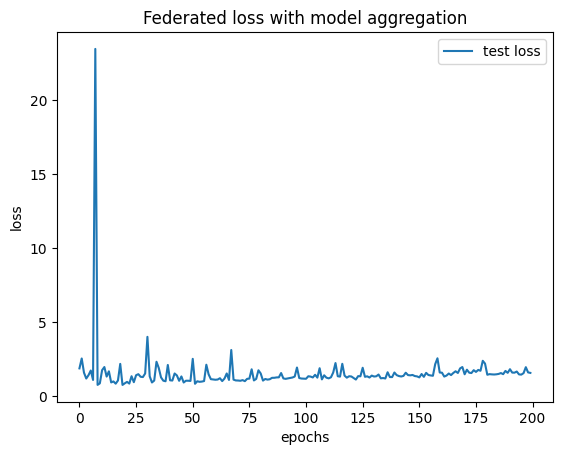

In [24]:
ep = list(range(0, 200))

# Plot the second list
plt.plot(ep, test_loss, label='test loss')
# Add labels and title
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Federated loss with model aggregation')
# Add a legend
plt.legend()
# Show the plot
plt.show()

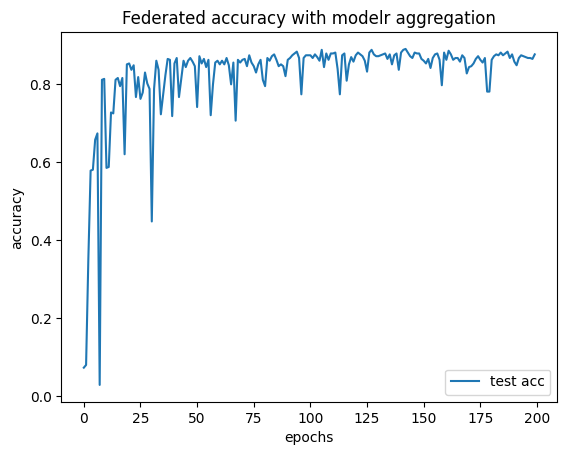

In [25]:
ep = list(range(0, 200))
# Plot the first list
# Plot the second list
plt.plot(ep, test_acc, label='test acc')
# Add labels and title
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('Federated accuracy with modelr aggregation')
# Add a legend
plt.legend()
# Show the plot
plt.show()

In [30]:
best_model = load_model('/mnt/c/Users/Dhruba/Codes/saved models/OCTDL_fd_dns.v_acc_0.881-loss_1.390.keras', compile = True)
#best_model.summary()

In [31]:
y_pred = best_model.predict(x_test, batch_size=50,  verbose=0)

sparse_gt = np.argmax(y_test_encoded, axis=1)
sparse_pred = np.argmax(y_pred, axis=1)

### Calculate accuracy
accuracy = accuracy_score(sparse_gt, sparse_pred)
#print("Accuracy:", accuracy)

cm = confusion_matrix(sparse_gt, sparse_pred)
# Calculate macro-averaged AUC
macro_auc = roc_auc_score(sparse_gt, y_pred, multi_class="ovr", average="macro") 
# Calculate micro-averaged AUC
micro_auc = roc_auc_score(sparse_gt, y_pred, multi_class="ovr", average="micro") 

print("Accuracy of model on full test data: ", accuracy)
print("Macro-averaged AUC on full test data: ", macro_auc)
print("Micro-averaged AUC on full test data: ", micro_auc)
# # Calculate precision, recall, and F1-score for each class
# precision = precision_score(y, sparse_pred, average=None)
# recall = recall_score(y, sparse_pred, average=None)
# f1 = f1_score(y, sparse_pred, average=None)

# # Calculate macro, micro, and weighted scores
# macro_f1 = f1_score(y, sparse_pred, average='macro')
# micro_f1 = f1_score(y, sparse_pred, average='micro')
# weighted_f1 = f1_score(y, sparse_pred, average='weighted')

Accuracy of model on full test data:  0.8811188811188811
Macro-averaged AUC on full test data:  0.9607118207322713
Micro-averaged AUC on full test data:  0.9825858549634773


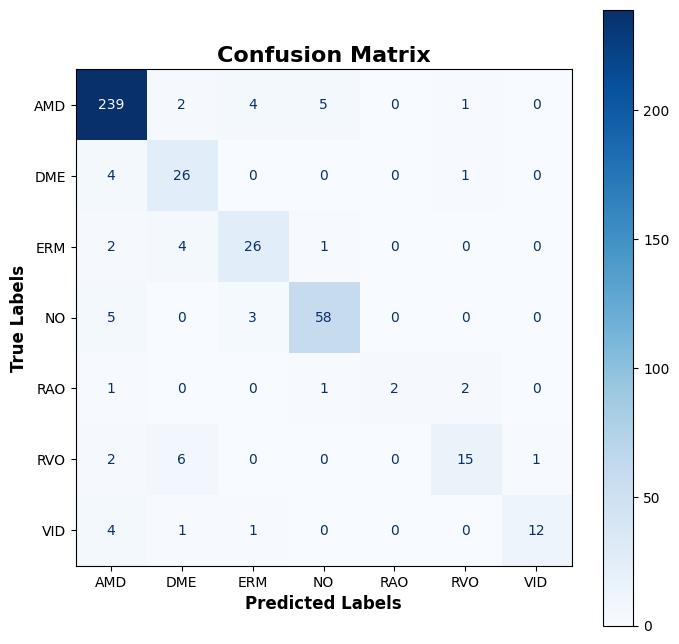

In [32]:
class_names = ['AMD', 'DME', 'ERM', 'NO', 'RAO', 'RVO', 'VID']
plt.figure(figsize=(8, 8))
# Create ConfusionMatrixDisplay object
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

## Plot the confusion matrix
disp.plot(cmap=plt.cm.Blues, ax=plt.gca(), colorbar=True)
## Rotate x-axis labels
plt.xticks(rotation=0)

# Customize the title and axis labels
plt.title("Confusion Matrix", fontsize=16, fontweight='bold')
plt.xlabel("Predicted Labels", fontsize=12, fontweight='bold')
plt.ylabel("True Labels", fontsize=12, fontweight='bold')

#plt.tight_layout()
plt.show()

In [33]:
# Print classification report
report = classification_report(sparse_gt, sparse_pred, target_names=[f"Class {i}" for i in range(7)])
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

     Class 0       0.93      0.95      0.94       251
     Class 1       0.67      0.84      0.74        31
     Class 2       0.76      0.79      0.78        33
     Class 3       0.89      0.88      0.89        66
     Class 4       1.00      0.33      0.50         6
     Class 5       0.79      0.62      0.70        24
     Class 6       0.92      0.67      0.77        18

    accuracy                           0.88       429
   macro avg       0.85      0.73      0.76       429
weighted avg       0.89      0.88      0.88       429

